# Question 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
class DifferentialAttention(nn.Module):
    def __init__(self, dim, lambda_init=0.5):
        super().__init__()
        self.dim = dim
        self.scale = dim ** -0.5
        self.lambda_init = lambda_init
        
        self.q1 = nn.Linear(dim, dim)
        self.k1 = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        
        self.q2 = nn.Linear(dim, dim)
        self.k2 = nn.Linear(dim, dim)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        q1 = self.q1(x)  
        k1 = self.k1(x)  
        v = self.v(x)    
        
        q2 = self.q2(x)  
        k2 = self.k2(x)  
        
        attn1 = (q1 @ k1.transpose(-2, -1)) * self.scale 
        attn1 = F.softmax(attn1, dim=-1)
        
        attn2 = (q2 @ k2.transpose(-2, -1)) * self.scale  
        attn2 = F.softmax(attn2, dim=-1)
        
        diff_attn = attn1 - self.lambda_init * attn2 
        out = diff_attn @ v  
        
        out = out * (1 - self.lambda_init)
        
        return out


class MultiHeadDifferentialAttention(nn.Module):
    def __init__(self, dim, num_heads=8, lambda_init=0.5, qkv_bias=False, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.lambda_init = lambda_init
        
        self.q1 = nn.Linear(dim, dim, bias=qkv_bias)
        self.k1 = nn.Linear(dim, dim, bias=qkv_bias)
        
        self.q2 = nn.Linear(dim, dim, bias=qkv_bias)
        self.k2 = nn.Linear(dim, dim, bias=qkv_bias)
        
        self.v = nn.Linear(dim, dim, bias=qkv_bias)
        
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, seq_len, dim = x.shape
        
        q1 = self.q1(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k1 = self.k1(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        q2 = self.q2(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k2 = self.k2(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        attn1 = (q1 @ k1.transpose(-2, -1)) * self.scale
        attn1 = F.softmax(attn1, dim=-1)
        
        attn2 = (q2 @ k2.transpose(-2, -1)) * self.scale
        attn2 = F.softmax(attn2, dim=-1)
        
        diff_attn = attn1 - self.lambda_init * attn2
        
        out = (diff_attn @ v).transpose(1, 2).reshape(batch_size, seq_len, dim)
        out = out * (1 - self.lambda_init)
        
        out = self.proj(out)
        out = self.proj_drop(out)
        
        self.attn1 = attn1.detach()
        self.attn2 = attn2.detach()
        self.diff_attn = diff_attn.detach()
        
        return out

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)  
        x = x.flatten(2)  
        x = x.transpose(1, 2)  
        return x


class MLPBlock(nn.Module):
    def __init__(self, dim, mlp_ratio=4, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, int(dim * mlp_ratio))
        self.fc2 = nn.Linear(int(dim * mlp_ratio), dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class DiffTransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4, lambda_init=0.5, qkv_bias=False, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        
        self.attn = MultiHeadDifferentialAttention(
            dim=dim, 
            num_heads=num_heads, 
            lambda_init=lambda_init, 
            qkv_bias=qkv_bias
        )
        
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLPBlock(dim, mlp_ratio, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))        
        x = x + self.dropout(self.mlp(self.norm2(x)))
        
        return x

In [16]:
class DifferentialVisionTransformer(nn.Module):
    def __init__(
        self, 
        img_size=32, 
        patch_size=4, 
        in_channels=3, 
        num_classes=10,
        embed_dim=768, 
        depth=12, 
        num_heads=12, 
        mlp_ratio=4, 
        lambda_init=0.5,
        qkv_bias=True, 
        dropout=0.0,
        pos_embed_type='learned_1d'  
    ):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_patches = (img_size // patch_size) ** 2
        self.pos_embed_type = pos_embed_type
        
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        torch.nn.init.normal_(self.cls_token, std=0.02)
        
        if pos_embed_type == 'none':
            self.pos_embed = None
        elif pos_embed_type == 'learned_1d':
            self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
            torch.nn.init.normal_(self.pos_embed, std=0.02)
        elif pos_embed_type == 'learned_2d':
            h, w = img_size // patch_size, img_size // patch_size
            self.pos_embed_h = nn.Parameter(torch.zeros(1, h, w, self.embed_dim))
            self.pos_embed_w = nn.Parameter(torch.zeros(1, h, w, self.embed_dim))
            self.cls_pos_embed = nn.Parameter(torch.zeros(1, 1, embed_dim))
            torch.nn.init.normal_(self.pos_embed_h, std=0.02)
            torch.nn.init.normal_(self.pos_embed_w, std=0.02)
            torch.nn.init.normal_(self.cls_pos_embed, std=0.02)
        elif pos_embed_type == 'sinusoidal':
            position = torch.arange(self.num_patches + 1).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
            pos_embed = torch.zeros(1, self.num_patches + 1, embed_dim)
            pos_embed[0, :, 0::2] = torch.sin(position * div_term)
            pos_embed[0, :, 1::2] = torch.cos(position * div_term)
            self.register_buffer('pos_embed', pos_embed)
        
        self.pos_dropout = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            DiffTransformerEncoderBlock(
                dim=embed_dim, 
                num_heads=num_heads, 
                mlp_ratio=mlp_ratio, 
                lambda_init=lambda_init,
                qkv_bias=qkv_bias, 
                dropout=dropout
            )
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)        
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x) 
        
        cls_tokens = self.cls_token.expand(B, -1, -1)  
        x = torch.cat((cls_tokens, x), dim=1) 
        
        if self.pos_embed_type == 'none':
            pass  
        elif self.pos_embed_type == 'learned_1d':
            x = x + self.pos_embed 
        elif self.pos_embed_type == 'learned_2d':
            h, w = int(np.sqrt(self.num_patches)), int(np.sqrt(self.num_patches))
            x_patches = x[:, 1:, :].reshape(B, h, w, self.embed_dim)
            
            x_patches_h = x_patches + self.pos_embed_h  
            x_patches_w = x_patches + self.pos_embed_w  
            
            x_patches = torch.cat([x_patches_h[..., :self.embed_dim//2], 
                                 x_patches_w[..., self.embed_dim//2:]], dim=-1)
            
            x_patches = x_patches.reshape(B, self.num_patches, self.embed_dim)
            cls_with_pos = cls_tokens + self.cls_pos_embed
            x = torch.cat([cls_with_pos, x_patches], dim=1)
        elif self.pos_embed_type == 'sinusoidal':
            x = x + self.pos_embed 
        
        x = self.pos_dropout(x)
        
        self.attention_maps = []
        
        for block in self.blocks:
            x = block(x)
            if hasattr(block.attn, 'attn1') and hasattr(block.attn, 'attn2'):
                self.attention_maps.append({
                    'attn1': block.attn.attn1.detach(),
                    'attn2': block.attn.attn2.detach(),
                    'diff_attn': block.attn.diff_attn.detach()
                })
        
        x = self.norm(x)
        x = x[:, 0]  
        x = self.head(x)  
        
        return x
    
    def get_attention_maps(self, x, layer_idx=-1, head_idx=None):
        _ = self.forward(x)
        
        if layer_idx < 0:
            layer_idx = len(self.blocks) + layer_idx
        
        attn_maps = self.attention_maps[layer_idx]        
        diff_attn = attn_maps['diff_attn']  
        cls_to_patch_attn = diff_attn[:, :, 0, 1:]  
        if head_idx is not None:
            cls_to_patch_attn = cls_to_patch_attn[:, head_idx, :]  # [B, n_patches]
        
        return cls_to_patch_attn

    def attention_rollout(self, x):
        _ = self.forward(x)
        
        batch_size = x.shape[0]
        seq_len = self.num_patches + 1 
        eye = torch.eye(seq_len).unsqueeze(0).repeat(batch_size, 1, 1).to(x.device)
        
        rolled_out_attn = eye
        
        for i, block in enumerate(self.blocks):
            if i < len(self.attention_maps):
                diff_attn = self.attention_maps[i]['diff_attn']  
                layer_attn = diff_attn.mean(dim=1)                  
                layer_attn = layer_attn + eye
                layer_attn = layer_attn / layer_attn.sum(dim=-1, keepdim=True)                
                rolled_out_attn = torch.bmm(layer_attn, rolled_out_attn)
        
        cls_rollout = rolled_out_attn[:, 0, 1:]  
        
        return cls_rollout


In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(dataloader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [7]:
def visualize_attention_maps(model, dataloader, device, num_images=5, layer_idx=-1):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images[:num_images].to(device)
    
    with torch.no_grad():
        cls_attention = model.get_attention_maps(images, layer_idx=layer_idx)    
    attention_maps = cls_attention.cpu().numpy()    
    fig, axes = plt.subplots(num_images, model.blocks[0].attn.num_heads + 2, figsize=(20, 4 * num_images))
    
    for i in range(num_images):
        ax = axes[i, 0]
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5 
        ax.imshow(img)
        ax.set_title(f"Image {i}")
        ax.axis('off')
        
        for h in range(model.blocks[0].attn.num_heads):
            ax = axes[i, h + 1]
            
            attn_map = attention_maps[i, h].reshape(int(np.sqrt(model.num_patches)), int(np.sqrt(model.num_patches)))
            
            im = ax.imshow(attn_map, cmap='hot')
            ax.set_title(f"Head {h}")
            ax.axis('off')
        
        ax = axes[i, -1]
        agg_attn = attention_maps[i].mean(axis=0).reshape(int(np.sqrt(model.num_patches)), int(np.sqrt(model.num_patches)))
        im = ax.imshow(agg_attn, cmap='hot')
        ax.set_title("Aggregated")
        ax.axis('off')
    
    plt.tight_layout()
    return fig

def visualize_attention_rollout(model, dataloader, device, num_images=5):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images[:num_images].to(device)
    
    with torch.no_grad():
        rollout_maps = model.attention_rollout(images)    
    rollout_maps = rollout_maps.cpu().numpy()    
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images))
    
    for i in range(num_images):
        ax = axes[i, 0]
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5
        ax.imshow(img)
        ax.set_title(f"Image {i}")
        ax.axis('off')
        
        ax = axes[i, 1]
        rollout_map = rollout_maps[i].reshape(int(np.sqrt(model.num_patches)), int(np.sqrt(model.num_patches)))
        im = ax.imshow(rollout_map, cmap='hot')
        ax.set_title("Attention Rollout")
        ax.axis('off')
    
    plt.tight_layout()
    return fig

def visualize_pos_embedding_similarity(model):
    if model.pos_embed_type != 'learned_1d':
        print("Positional embedding visualization only supported for learned_1d type")
        return None
    
    pos_embed = model.pos_embed[0, 1:, :].detach().cpu()
    
    similarity = torch.matmul(pos_embed, pos_embed.T)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity, cmap='viridis')
    ax.set_title("Positional Embedding Similarity")
    fig.colorbar(im, ax=ax)
    
    return fig

In [8]:
def get_cifar10_dataloaders(batch_size=128, patch_size=4, augment=False):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    if augment:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),  # Add rotation
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add color jitter
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
            transforms.RandomErasing(p=0.2)  # Add random erasing
        ])
    
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
    
    return trainloader, testloader

In [9]:
def train_model(config, trainloader, testloader, num_epochs=50, device=device):
    print(f"Training model with configuration: {config['name']}")
    
    model = DifferentialVisionTransformer(
        img_size=32,
        patch_size=config['patch_size'],
        in_channels=3,
        num_classes=10,
        embed_dim=config['embed_dim'],
        depth=config['depth'],
        num_heads=config['num_heads'],
        lambda_init=config['lambda_init'],
        pos_embed_type=config['pos_embed_type']
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        
        val_loss, val_acc = evaluate(model, testloader, criterion, device)
        
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return model, history

def plot_training_history(histories, config_names, metric='loss'):
    plt.figure(figsize=(12, 6))
    
    for i, history in enumerate(histories):
        if metric == 'loss':
            plt.plot(history['train_loss'], linestyle='--', label=f"{config_names[i]} (Train)")
            plt.plot(history['val_loss'], label=f"{config_names[i]} (Val)")
        else:  
            plt.plot(history['train_acc'], linestyle='--', label=f"{config_names[i]} (Train)")
            plt.plot(history['val_acc'], label=f"{config_names[i]} (Val)")
    
    plt.title(f"Training {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    
    return plt.gcf()

def compare_models(models, histories, config_names):
    test_accs = [history['val_acc'][-1] for history in histories]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(config_names, test_accs)
    
    for bar, acc in zip(bars, test_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{acc:.4f}", ha='center', va='bottom', rotation=0)
    
    plt.title("Test Accuracy Comparison")
    plt.xlabel("Model Configuration")
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1.0)
    plt.grid(axis='y')
    
    return plt.gcf()

In [17]:
batch_size = 128
num_epochs = 50

trainloader, testloader = get_cifar10_dataloaders(batch_size, augment=True)

configs = [
    {
        'name': 'Default',
        'patch_size': 4,
        'embed_dim': 384,
        'depth': 8,
        'num_heads': 6,
        'lambda_init': 0.5,
        'pos_embed_type': 'learned_1d'
    },
    {
        'name': 'Larger Model',
        'patch_size': 4,
        'embed_dim': 512,
        'depth': 12,
        'num_heads': 8,
        'lambda_init': 0.5,
        'pos_embed_type': 'learned_1d'
    },
    {
        'name': 'Lambda 0.3',
        'patch_size': 4,
        'embed_dim': 384,
        'depth': 8,
        'num_heads': 6,
        'lambda_init': 0.3,
        'pos_embed_type': 'learned_1d'
    },
    {
        'name': 'No Pos Embedding',
        'patch_size': 4,
        'embed_dim': 384,
        'depth': 8,
        'num_heads': 6,
        'lambda_init': 0.5,
        'pos_embed_type': 'none'
    },
    {
        'name': 'Sinusoidal',
        'patch_size': 4,
        'embed_dim': 384,
        'depth': 8,
        'num_heads': 6,
        'lambda_init': 0.5,
        'pos_embed_type': 'sinusoidal'
    },
    {
        'name': 'Patch Size 2',
        'patch_size': 2,
        'embed_dim': 256,
        'depth': 6,      
        'num_heads': 4,      
        'lambda_init': 0.5,
        'pos_embed_type': 'learned_1d'
    },
    {
        'name': 'Learned 2D',
        'patch_size': 4,
        'embed_dim': 384,  
        'depth': 8,
        'num_heads': 6,  
        'lambda_init': 0.5,
        'pos_embed_type': 'learned_2d'
    },
]


Training model with configuration: Default


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.97it/s]


Epoch 1/50: Train Loss: 2.1359, Train Acc: 0.1901, Val Loss: 2.0724, Val Acc: 0.2236


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.01it/s]


Epoch 2/50: Train Loss: 2.0199, Train Acc: 0.2331, Val Loss: 1.9645, Val Acc: 0.2640


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.55it/s]


Epoch 3/50: Train Loss: 1.9671, Train Acc: 0.2567, Val Loss: 1.9130, Val Acc: 0.2786


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.57it/s]


Epoch 4/50: Train Loss: 1.9892, Train Acc: 0.2512, Val Loss: 1.9375, Val Acc: 0.2826


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.53it/s]


Epoch 5/50: Train Loss: 2.0115, Train Acc: 0.2415, Val Loss: 1.9307, Val Acc: 0.2799


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


Epoch 6/50: Train Loss: 1.9565, Train Acc: 0.2657, Val Loss: 1.9139, Val Acc: 0.2859


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.79it/s]


Epoch 7/50: Train Loss: 1.9285, Train Acc: 0.2779, Val Loss: 1.8567, Val Acc: 0.3018


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.77it/s]


Epoch 8/50: Train Loss: 1.9464, Train Acc: 0.2723, Val Loss: 1.9092, Val Acc: 0.2972


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.38it/s]


Epoch 9/50: Train Loss: 1.9065, Train Acc: 0.2875, Val Loss: 1.8713, Val Acc: 0.3059


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.32it/s]


Epoch 10/50: Train Loss: 1.8853, Train Acc: 0.2954, Val Loss: 1.8780, Val Acc: 0.3089


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.83it/s]


Epoch 11/50: Train Loss: 1.8897, Train Acc: 0.2921, Val Loss: 1.8983, Val Acc: 0.2946


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.92it/s]


Epoch 12/50: Train Loss: 1.8690, Train Acc: 0.3005, Val Loss: 1.8647, Val Acc: 0.3008


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.47it/s]


Epoch 13/50: Train Loss: 1.8395, Train Acc: 0.3124, Val Loss: 1.8313, Val Acc: 0.3129


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.82it/s]


Epoch 14/50: Train Loss: 1.8588, Train Acc: 0.3071, Val Loss: 1.8765, Val Acc: 0.3164


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.85it/s]


Epoch 15/50: Train Loss: 1.8294, Train Acc: 0.3173, Val Loss: 1.7991, Val Acc: 0.3304


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.60it/s]


Epoch 16/50: Train Loss: 1.8093, Train Acc: 0.3241, Val Loss: 1.8156, Val Acc: 0.3284


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.83it/s]


Epoch 17/50: Train Loss: 1.8005, Train Acc: 0.3297, Val Loss: 1.7892, Val Acc: 0.3386


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.64it/s]


Epoch 18/50: Train Loss: 1.7691, Train Acc: 0.3406, Val Loss: 1.7220, Val Acc: 0.3628


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.75it/s]


Epoch 19/50: Train Loss: 1.7418, Train Acc: 0.3509, Val Loss: 1.6897, Val Acc: 0.3773


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.62it/s]


Epoch 20/50: Train Loss: 1.7315, Train Acc: 0.3603, Val Loss: 1.7271, Val Acc: 0.3619


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.55it/s]


Epoch 21/50: Train Loss: 1.7126, Train Acc: 0.3653, Val Loss: 1.7084, Val Acc: 0.3738


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.83it/s]


Epoch 22/50: Train Loss: 1.6948, Train Acc: 0.3735, Val Loss: 1.6804, Val Acc: 0.3824


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.66it/s]


Epoch 23/50: Train Loss: 1.6648, Train Acc: 0.3826, Val Loss: 1.6358, Val Acc: 0.3945


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.68it/s]


Epoch 24/50: Train Loss: 1.6456, Train Acc: 0.3934, Val Loss: 1.5877, Val Acc: 0.4120


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.92it/s]


Epoch 25/50: Train Loss: 1.6192, Train Acc: 0.4050, Val Loss: 1.6039, Val Acc: 0.4133


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.72it/s]


Epoch 26/50: Train Loss: 1.5946, Train Acc: 0.4103, Val Loss: 1.5674, Val Acc: 0.4202


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.64it/s]


Epoch 27/50: Train Loss: 1.5764, Train Acc: 0.4202, Val Loss: 1.5431, Val Acc: 0.4330


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.65it/s]


Epoch 28/50: Train Loss: 1.5571, Train Acc: 0.4270, Val Loss: 1.5339, Val Acc: 0.4405


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.53it/s]


Epoch 29/50: Train Loss: 1.5356, Train Acc: 0.4364, Val Loss: 1.5328, Val Acc: 0.4450


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.90it/s]


Epoch 30/50: Train Loss: 1.5176, Train Acc: 0.4427, Val Loss: 1.5241, Val Acc: 0.4514


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


Epoch 31/50: Train Loss: 1.5072, Train Acc: 0.4517, Val Loss: 1.4997, Val Acc: 0.4529


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.54it/s]


Epoch 32/50: Train Loss: 1.4843, Train Acc: 0.4569, Val Loss: 1.4565, Val Acc: 0.4745


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.75it/s]


Epoch 33/50: Train Loss: 1.4689, Train Acc: 0.4650, Val Loss: 1.4506, Val Acc: 0.4776


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.89it/s]


Epoch 34/50: Train Loss: 1.4479, Train Acc: 0.4721, Val Loss: 1.4319, Val Acc: 0.4893


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.67it/s]


Epoch 35/50: Train Loss: 1.4341, Train Acc: 0.4782, Val Loss: 1.4050, Val Acc: 0.4900


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.67it/s]


Epoch 36/50: Train Loss: 1.4226, Train Acc: 0.4811, Val Loss: 1.3945, Val Acc: 0.4980


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.81it/s]


Epoch 37/50: Train Loss: 1.4081, Train Acc: 0.4883, Val Loss: 1.4003, Val Acc: 0.4959


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.59it/s]


Epoch 38/50: Train Loss: 1.3925, Train Acc: 0.4933, Val Loss: 1.3916, Val Acc: 0.5050


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.79it/s]


Epoch 39/50: Train Loss: 1.3727, Train Acc: 0.4995, Val Loss: 1.3700, Val Acc: 0.5060


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.94it/s]


Epoch 40/50: Train Loss: 1.3669, Train Acc: 0.5035, Val Loss: 1.3673, Val Acc: 0.5067


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.93it/s]


Epoch 41/50: Train Loss: 1.3612, Train Acc: 0.5085, Val Loss: 1.3697, Val Acc: 0.5096


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.60it/s]


Epoch 42/50: Train Loss: 1.3481, Train Acc: 0.5127, Val Loss: 1.3671, Val Acc: 0.5136


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.45it/s]


Epoch 43/50: Train Loss: 1.3349, Train Acc: 0.5159, Val Loss: 1.3468, Val Acc: 0.5190


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.82it/s]


Epoch 44/50: Train Loss: 1.3349, Train Acc: 0.5146, Val Loss: 1.3495, Val Acc: 0.5206


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.71it/s]


Epoch 45/50: Train Loss: 1.3286, Train Acc: 0.5198, Val Loss: 1.3460, Val Acc: 0.5188


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.47it/s]


Epoch 46/50: Train Loss: 1.3232, Train Acc: 0.5208, Val Loss: 1.3444, Val Acc: 0.5221


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.99it/s]


Epoch 47/50: Train Loss: 1.3202, Train Acc: 0.5204, Val Loss: 1.3467, Val Acc: 0.5197


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.82it/s]


Epoch 48/50: Train Loss: 1.3174, Train Acc: 0.5229, Val Loss: 1.3408, Val Acc: 0.5231


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.58it/s]


Epoch 49/50: Train Loss: 1.3128, Train Acc: 0.5249, Val Loss: 1.3407, Val Acc: 0.5243


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.49it/s]


Epoch 50/50: Train Loss: 1.3157, Train Acc: 0.5214, Val Loss: 1.3392, Val Acc: 0.5238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.4979501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4629833..1.5354269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22441113..1.4005105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4391681..1.2814069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49

Experiment completed and results saved!


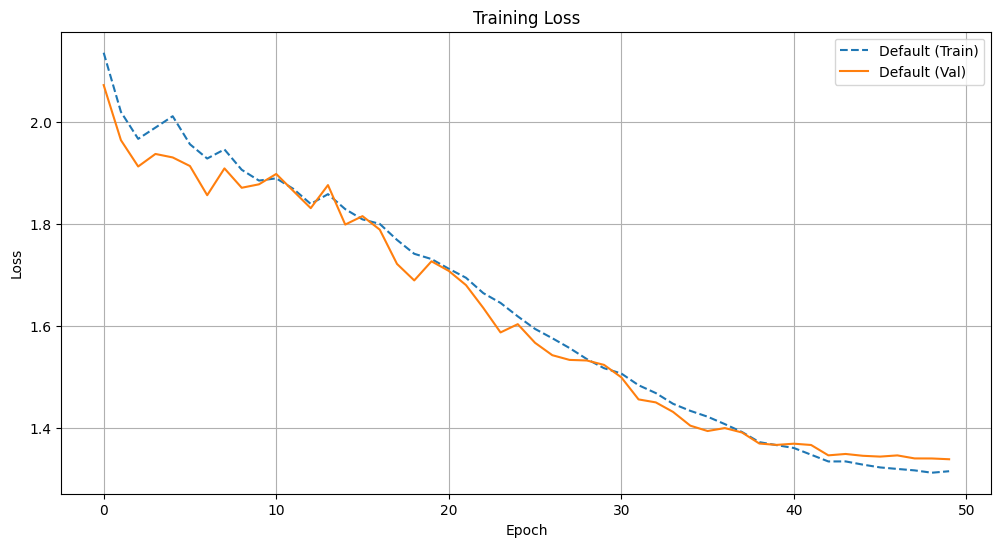

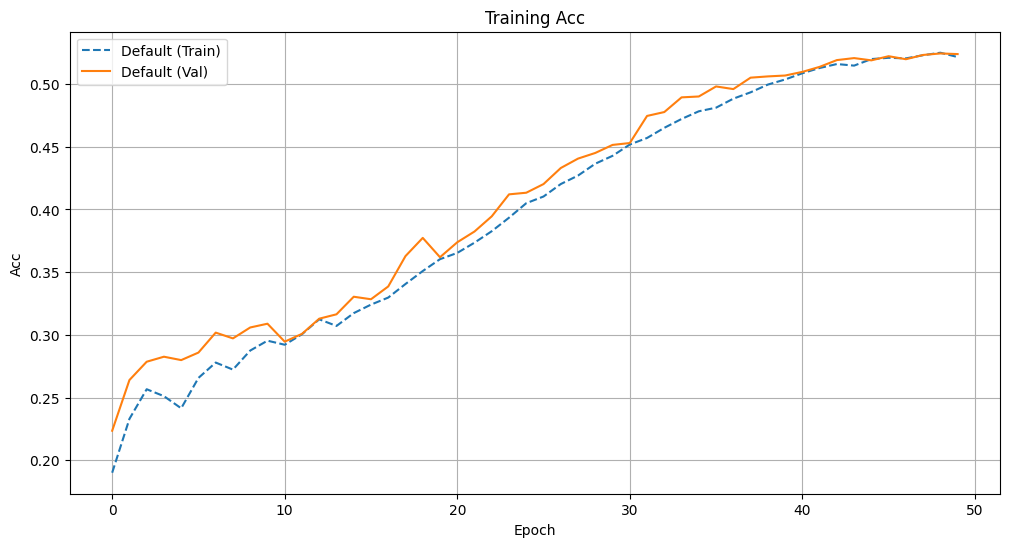

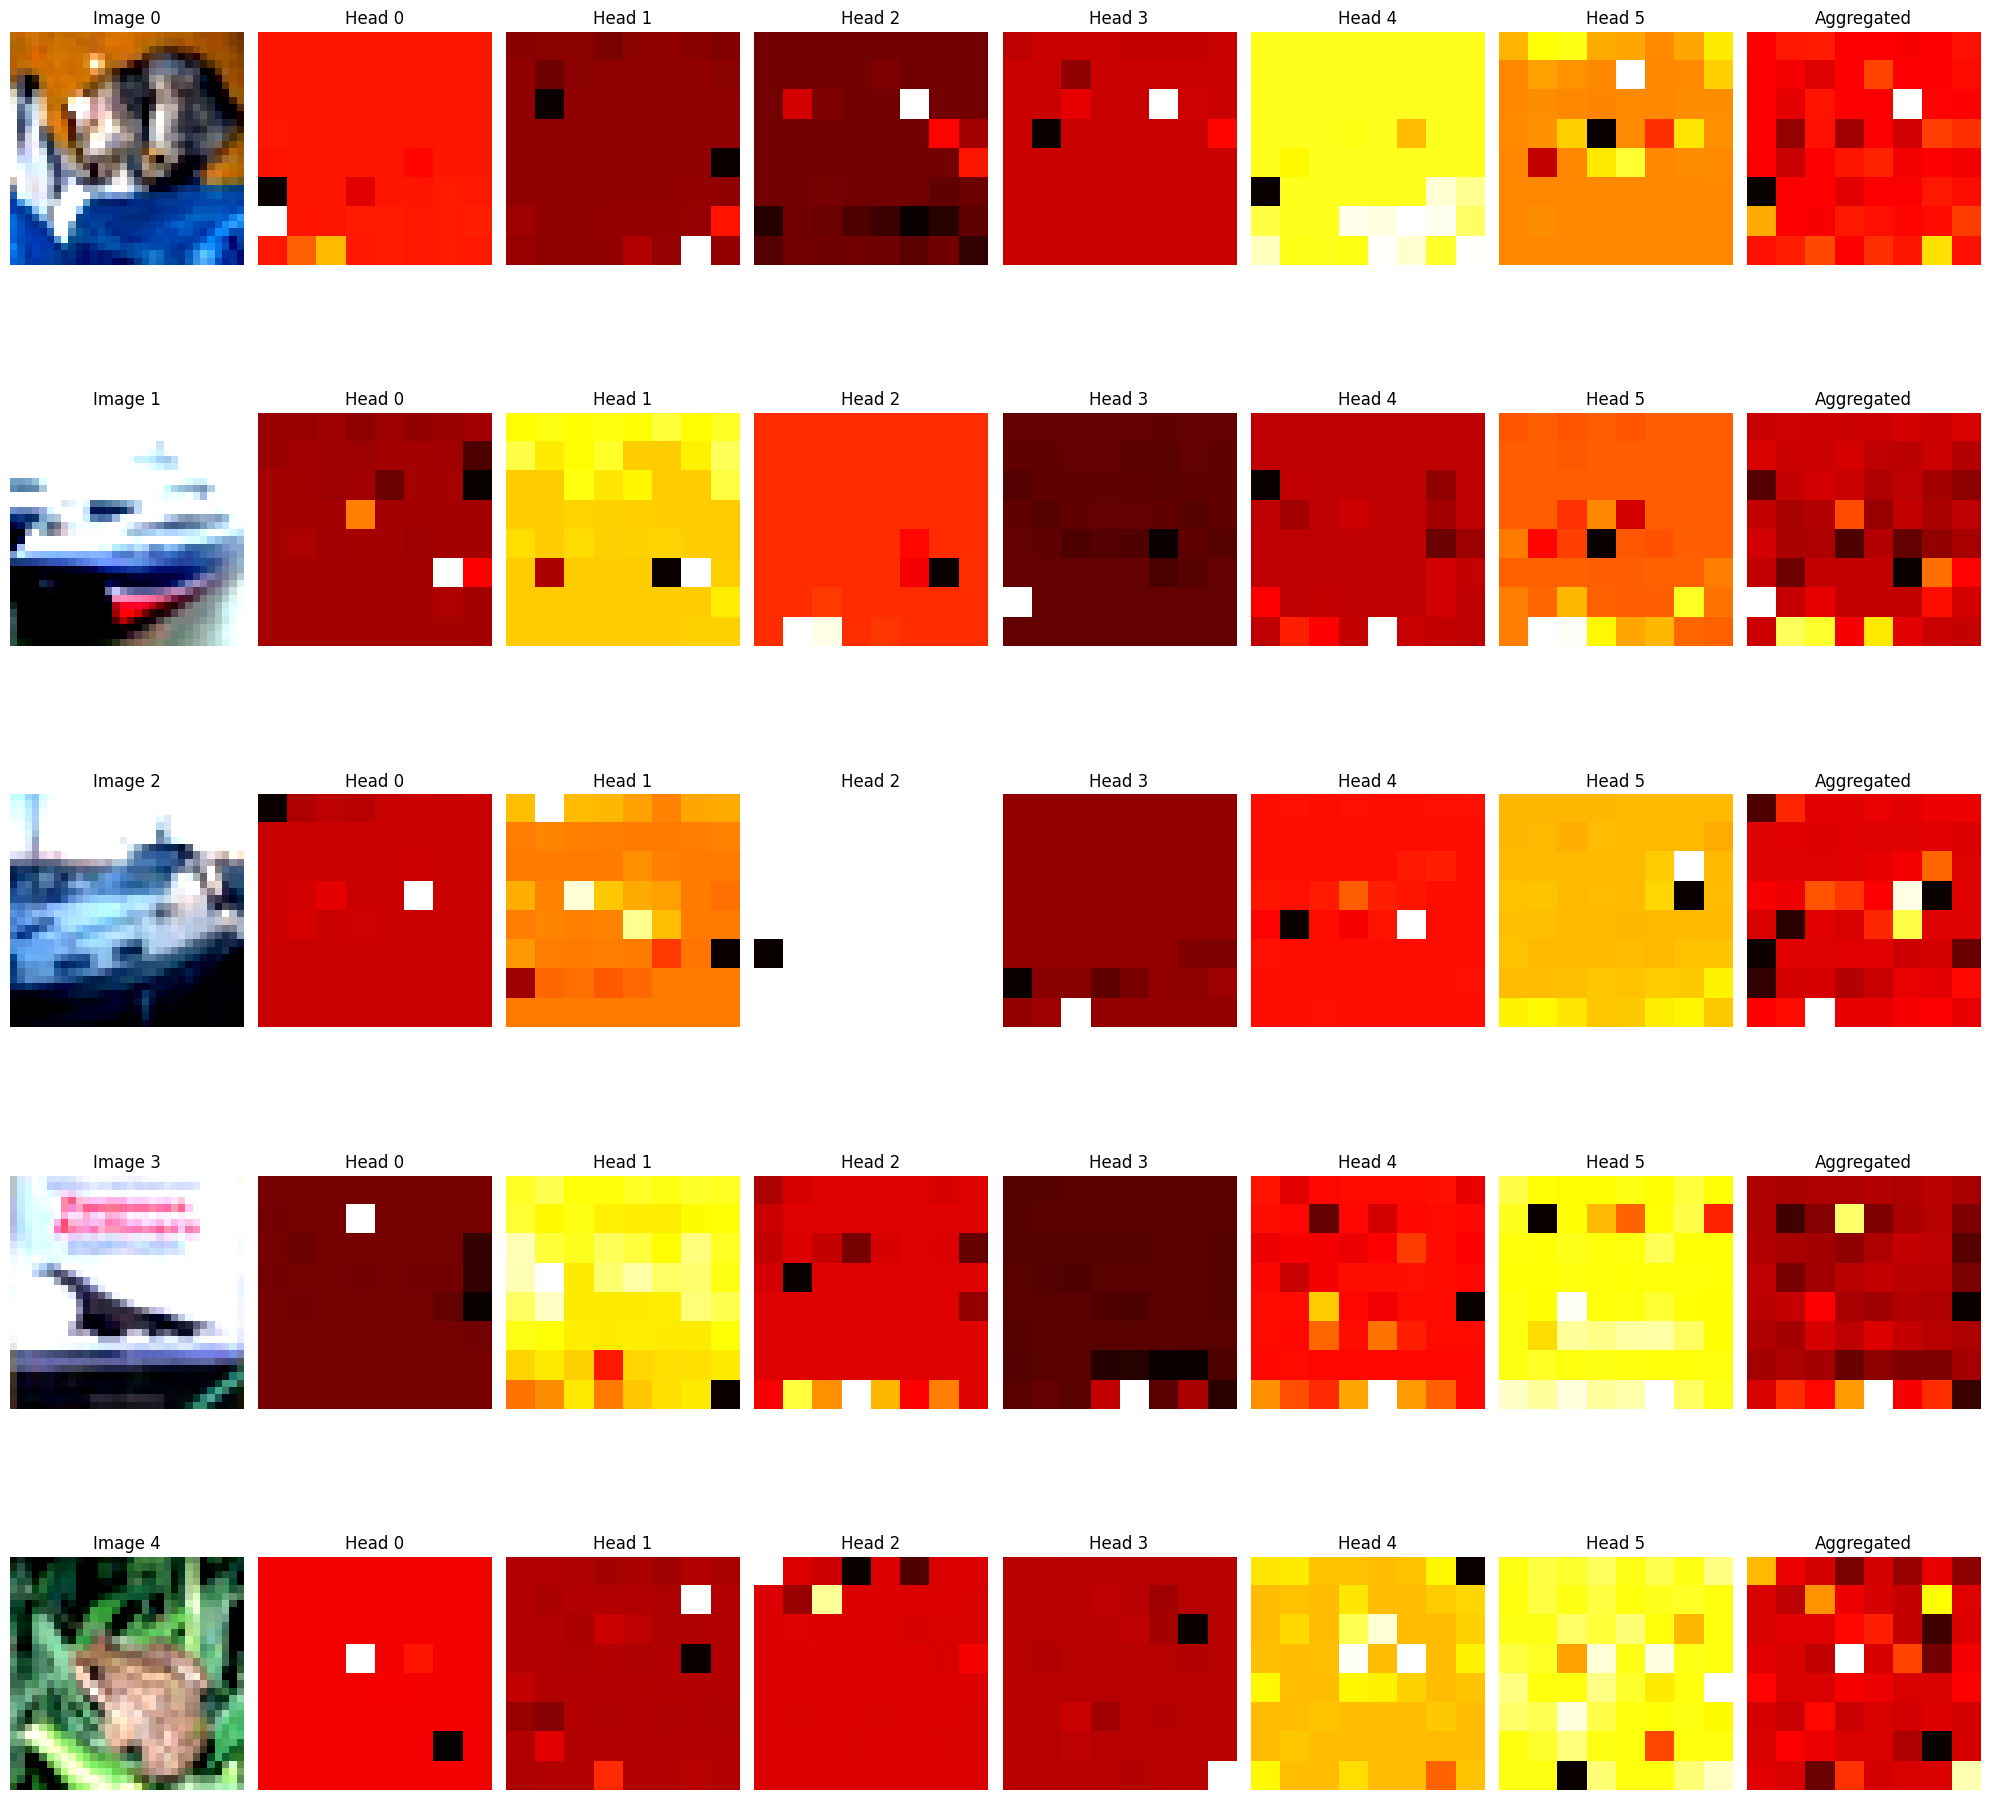

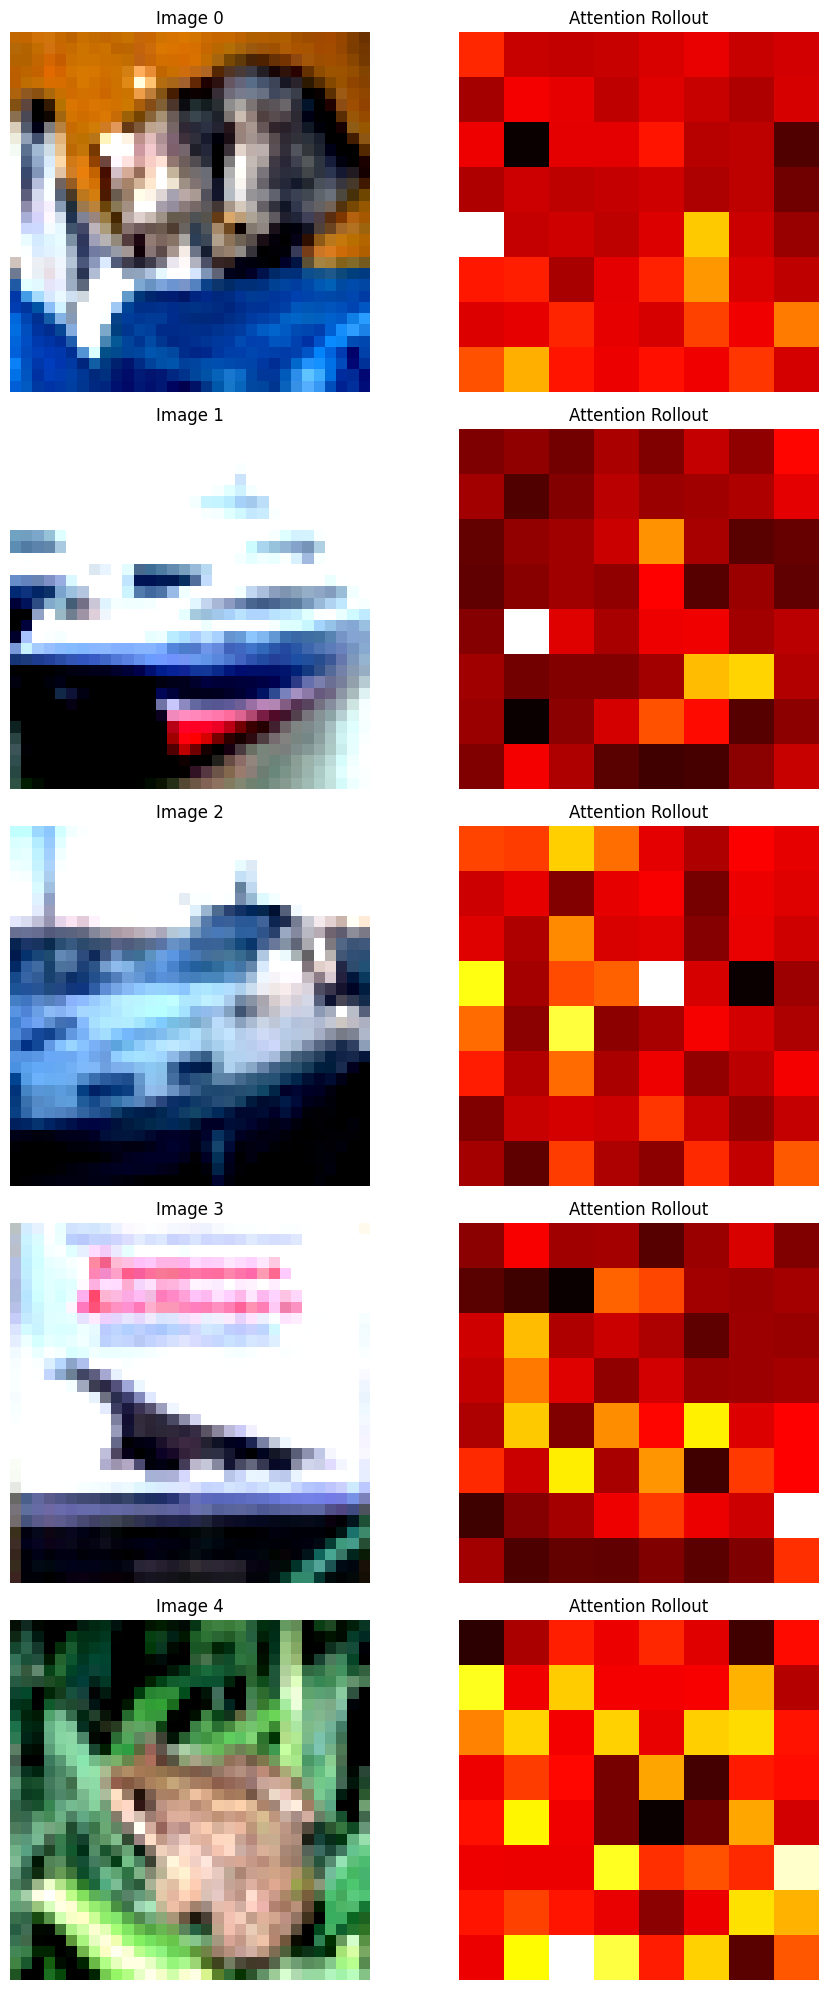

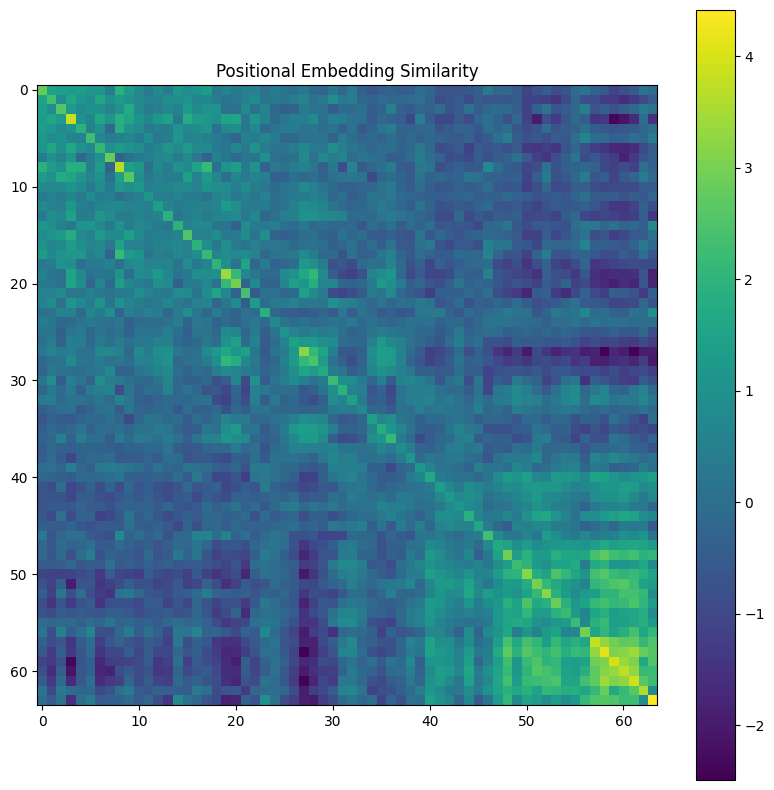

In [11]:
num_epochs = 50
selected_config = configs[0]  

model, history = train_model(selected_config, trainloader, testloader, num_epochs=num_epochs)

torch.save(model.state_dict(), f"results/diff_vit_{selected_config['name']}.pth")

fig = plot_training_history([history], [selected_config['name']], metric='loss')
fig.savefig(f"results/loss_curve_{selected_config['name']}.png")

fig = plot_training_history([history], [selected_config['name']], metric='acc')
fig.savefig(f"results/acc_curve_{selected_config['name']}.png")

fig = visualize_attention_maps(model, testloader, device)
fig.savefig(f"results/attention_maps_{selected_config['name']}.png")

fig = visualize_attention_rollout(model, testloader, device)
fig.savefig(f"results/attention_rollout_{selected_config['name']}.png")

if selected_config['pos_embed_type'] == 'learned_1d':
    fig = visualize_pos_embedding_similarity(model)
    if fig:
        fig.savefig(f"results/pos_embed_similarity_{selected_config['name']}.png")

print("Experiment completed and results saved!")


Training model with configuration: Larger Model


Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.43it/s]


Epoch 1/50: Train Loss: 2.3274, Train Acc: 0.1285, Val Loss: 2.1356, Val Acc: 0.1698


Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.30it/s]


Epoch 2/50: Train Loss: 2.0984, Train Acc: 0.1945, Val Loss: 2.0370, Val Acc: 0.2172


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.28it/s]


Epoch 3/50: Train Loss: 2.0471, Train Acc: 0.2169, Val Loss: 2.0023, Val Acc: 0.2348


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.19it/s]


Epoch 4/50: Train Loss: 2.0280, Train Acc: 0.2265, Val Loss: 2.1160, Val Acc: 0.1940


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.29it/s]


Epoch 5/50: Train Loss: 2.0794, Train Acc: 0.1986, Val Loss: 2.0823, Val Acc: 0.2041


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.30it/s]


Epoch 6/50: Train Loss: 2.0650, Train Acc: 0.2078, Val Loss: 2.0326, Val Acc: 0.2267


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


Epoch 7/50: Train Loss: 2.0414, Train Acc: 0.2181, Val Loss: 2.0189, Val Acc: 0.2260


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.32it/s]


Epoch 8/50: Train Loss: 2.0135, Train Acc: 0.2321, Val Loss: 1.9806, Val Acc: 0.2488


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.25it/s]


Epoch 9/50: Train Loss: 2.0358, Train Acc: 0.2276, Val Loss: 2.0050, Val Acc: 0.2465


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


Epoch 10/50: Train Loss: 2.0140, Train Acc: 0.2344, Val Loss: 1.9703, Val Acc: 0.2458


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.23it/s]


Epoch 11/50: Train Loss: 2.0183, Train Acc: 0.2330, Val Loss: 1.9986, Val Acc: 0.2398


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


Epoch 12/50: Train Loss: 2.0303, Train Acc: 0.2289, Val Loss: 2.0193, Val Acc: 0.2377


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.22it/s]


Epoch 13/50: Train Loss: 1.9921, Train Acc: 0.2395, Val Loss: 1.9478, Val Acc: 0.2461


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


Epoch 14/50: Train Loss: 1.9737, Train Acc: 0.2465, Val Loss: 1.9331, Val Acc: 0.2673


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


Epoch 15/50: Train Loss: 1.9682, Train Acc: 0.2514, Val Loss: 1.9535, Val Acc: 0.2469


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


Epoch 16/50: Train Loss: 1.9573, Train Acc: 0.2518, Val Loss: 1.9280, Val Acc: 0.2589


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.28it/s]


Epoch 17/50: Train Loss: 1.9348, Train Acc: 0.2642, Val Loss: 1.9411, Val Acc: 0.2582


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


Epoch 18/50: Train Loss: 1.9493, Train Acc: 0.2603, Val Loss: 1.9169, Val Acc: 0.2698


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.30it/s]


Epoch 19/50: Train Loss: 1.9303, Train Acc: 0.2702, Val Loss: 1.8928, Val Acc: 0.2899


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.26it/s]


Epoch 20/50: Train Loss: 1.9203, Train Acc: 0.2712, Val Loss: 1.9104, Val Acc: 0.2737


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.26it/s]


Epoch 21/50: Train Loss: 1.9160, Train Acc: 0.2754, Val Loss: 1.8687, Val Acc: 0.2965


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.29it/s]


Epoch 22/50: Train Loss: 1.8931, Train Acc: 0.2876, Val Loss: 1.8636, Val Acc: 0.2964


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.23it/s]


Epoch 23/50: Train Loss: 1.8868, Train Acc: 0.2894, Val Loss: 1.8656, Val Acc: 0.3042


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


Epoch 24/50: Train Loss: 1.8777, Train Acc: 0.2984, Val Loss: 1.8483, Val Acc: 0.3037


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.28it/s]


Epoch 25/50: Train Loss: 1.8662, Train Acc: 0.2977, Val Loss: 1.8307, Val Acc: 0.3091


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.27it/s]


Epoch 26/50: Train Loss: 1.8543, Train Acc: 0.3051, Val Loss: 1.8486, Val Acc: 0.3089


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.28it/s]


Epoch 27/50: Train Loss: 1.8326, Train Acc: 0.3130, Val Loss: 1.8097, Val Acc: 0.3223


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.29it/s]


Epoch 28/50: Train Loss: 1.8241, Train Acc: 0.3179, Val Loss: 1.7926, Val Acc: 0.3302


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.29it/s]


Epoch 29/50: Train Loss: 1.8249, Train Acc: 0.3173, Val Loss: 1.8027, Val Acc: 0.3243


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.12it/s]


Epoch 30/50: Train Loss: 1.8063, Train Acc: 0.3252, Val Loss: 1.7898, Val Acc: 0.3325


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.32it/s]


Epoch 31/50: Train Loss: 1.7983, Train Acc: 0.3271, Val Loss: 1.7846, Val Acc: 0.3340


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.34it/s]


Epoch 32/50: Train Loss: 1.8008, Train Acc: 0.3283, Val Loss: 1.7970, Val Acc: 0.3322


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.25it/s]


Epoch 33/50: Train Loss: 1.7869, Train Acc: 0.3310, Val Loss: 1.7704, Val Acc: 0.3402


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.26it/s]


Epoch 34/50: Train Loss: 1.7744, Train Acc: 0.3368, Val Loss: 1.7522, Val Acc: 0.3408


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.32it/s]


Epoch 35/50: Train Loss: 1.7632, Train Acc: 0.3403, Val Loss: 1.7383, Val Acc: 0.3534


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.27it/s]


Epoch 36/50: Train Loss: 1.7515, Train Acc: 0.3482, Val Loss: 1.7291, Val Acc: 0.3515


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.14it/s]


Epoch 37/50: Train Loss: 1.7379, Train Acc: 0.3560, Val Loss: 1.7049, Val Acc: 0.3648


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.25it/s]


Epoch 38/50: Train Loss: 1.7281, Train Acc: 0.3561, Val Loss: 1.7060, Val Acc: 0.3613


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.34it/s]


Epoch 39/50: Train Loss: 1.7222, Train Acc: 0.3631, Val Loss: 1.6972, Val Acc: 0.3676


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.26it/s]


Epoch 40/50: Train Loss: 1.7190, Train Acc: 0.3630, Val Loss: 1.6923, Val Acc: 0.3697


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


Epoch 41/50: Train Loss: 1.7044, Train Acc: 0.3698, Val Loss: 1.6960, Val Acc: 0.3716


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.23it/s]


Epoch 42/50: Train Loss: 1.6954, Train Acc: 0.3724, Val Loss: 1.6806, Val Acc: 0.3781


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.21it/s]


Epoch 43/50: Train Loss: 1.6904, Train Acc: 0.3754, Val Loss: 1.6837, Val Acc: 0.3752


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.28it/s]


Epoch 44/50: Train Loss: 1.6880, Train Acc: 0.3730, Val Loss: 1.6700, Val Acc: 0.3793


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.30it/s]


Epoch 45/50: Train Loss: 1.6823, Train Acc: 0.3788, Val Loss: 1.6673, Val Acc: 0.3842


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.30it/s]


Epoch 46/50: Train Loss: 1.6764, Train Acc: 0.3806, Val Loss: 1.6672, Val Acc: 0.3824


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


Epoch 47/50: Train Loss: 1.6747, Train Acc: 0.3800, Val Loss: 1.6645, Val Acc: 0.3873


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.24it/s]


Epoch 48/50: Train Loss: 1.6779, Train Acc: 0.3782, Val Loss: 1.6673, Val Acc: 0.3855


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.30it/s]


Epoch 49/50: Train Loss: 1.6741, Train Acc: 0.3809, Val Loss: 1.6652, Val Acc: 0.3878


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.26it/s]


Epoch 50/50: Train Loss: 1.6723, Train Acc: 0.3829, Val Loss: 1.6649, Val Acc: 0.3885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.4979501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4629833..1.5354269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22441113..1.4005105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4391681..1.2814069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49

Experiment completed and results saved!


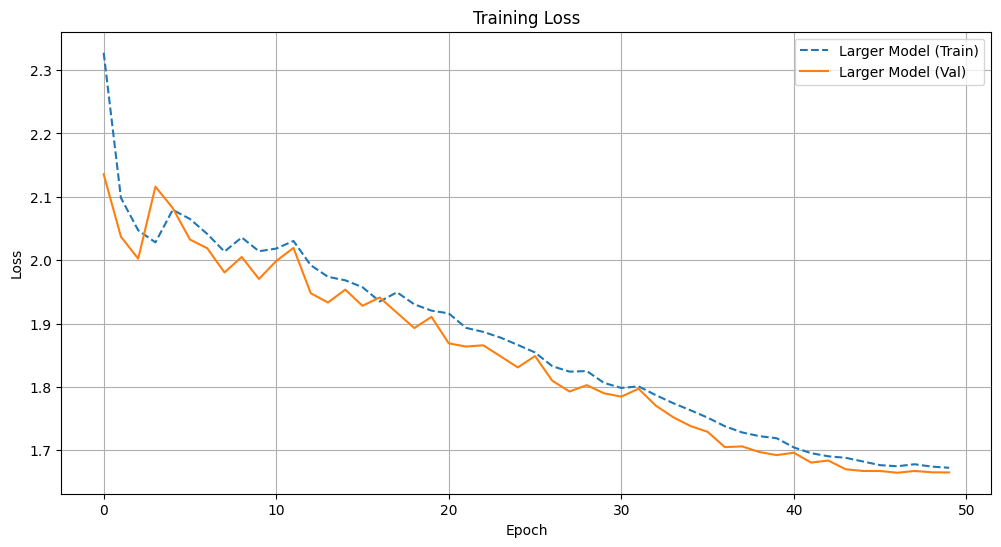

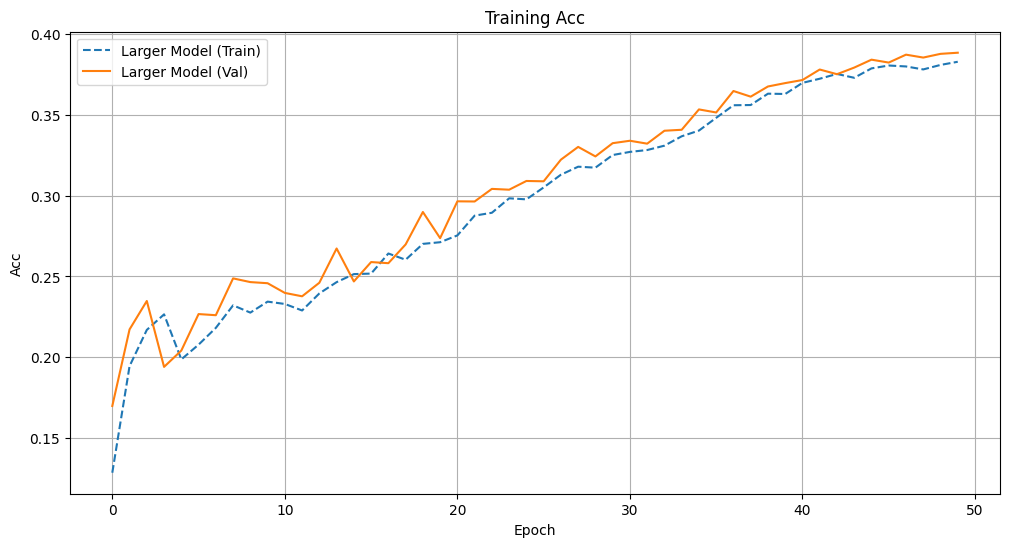

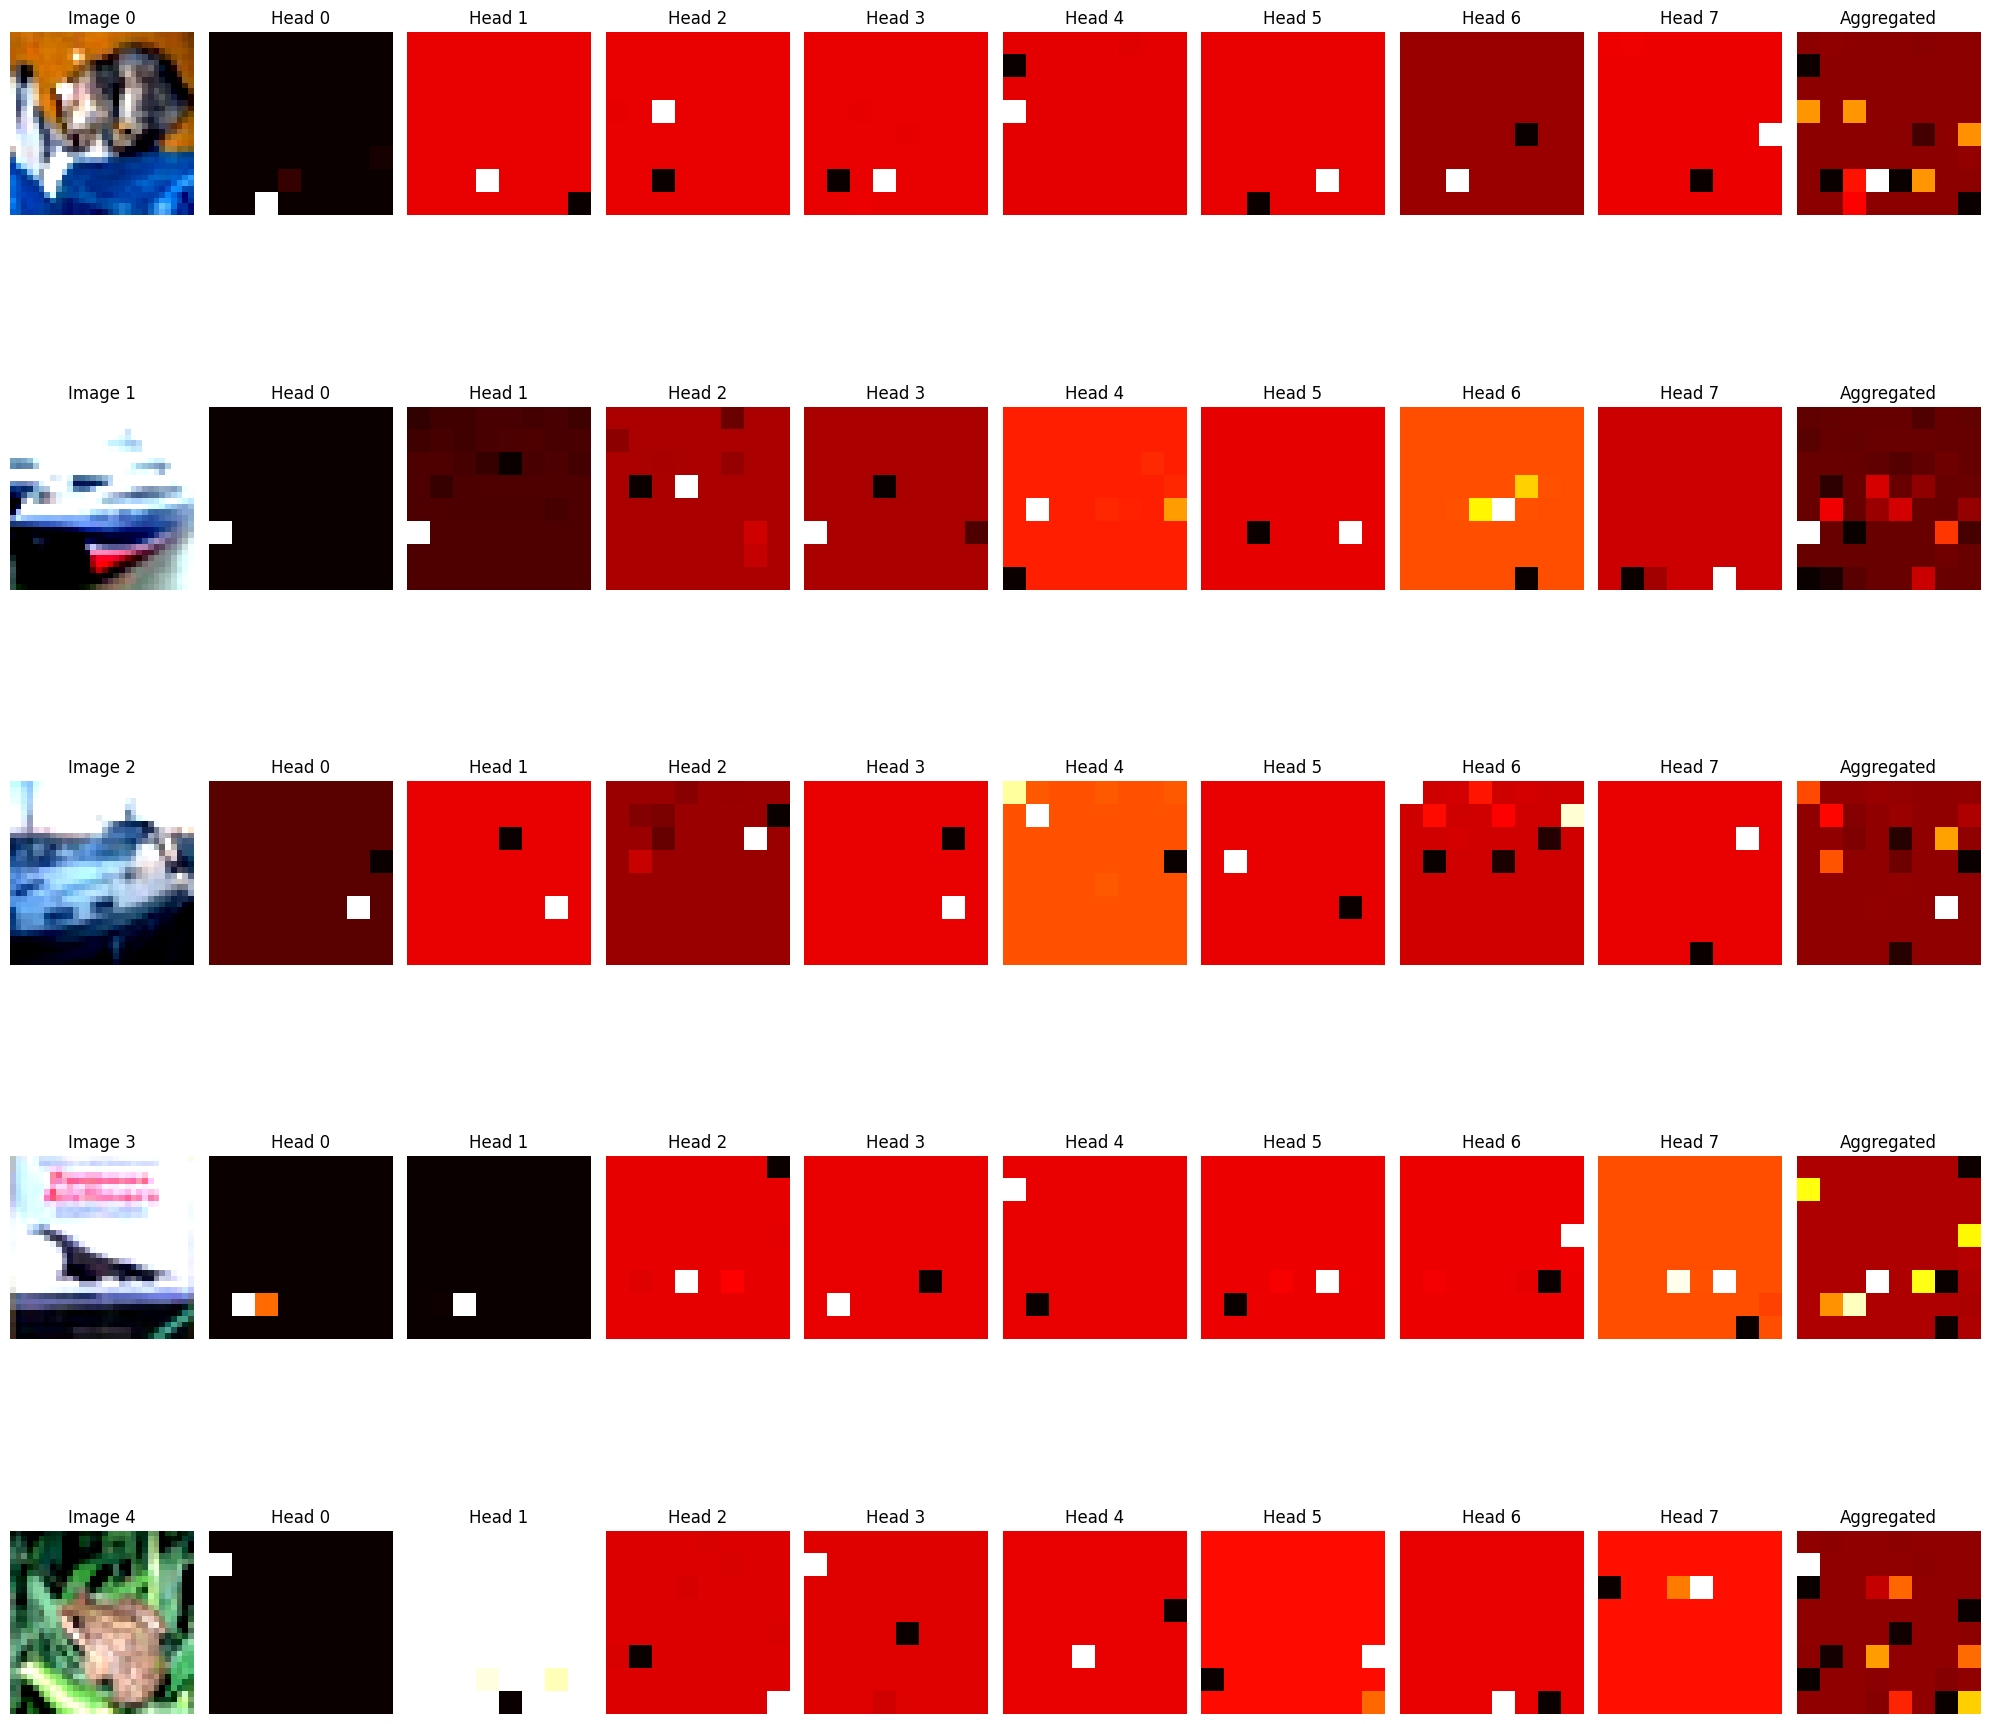

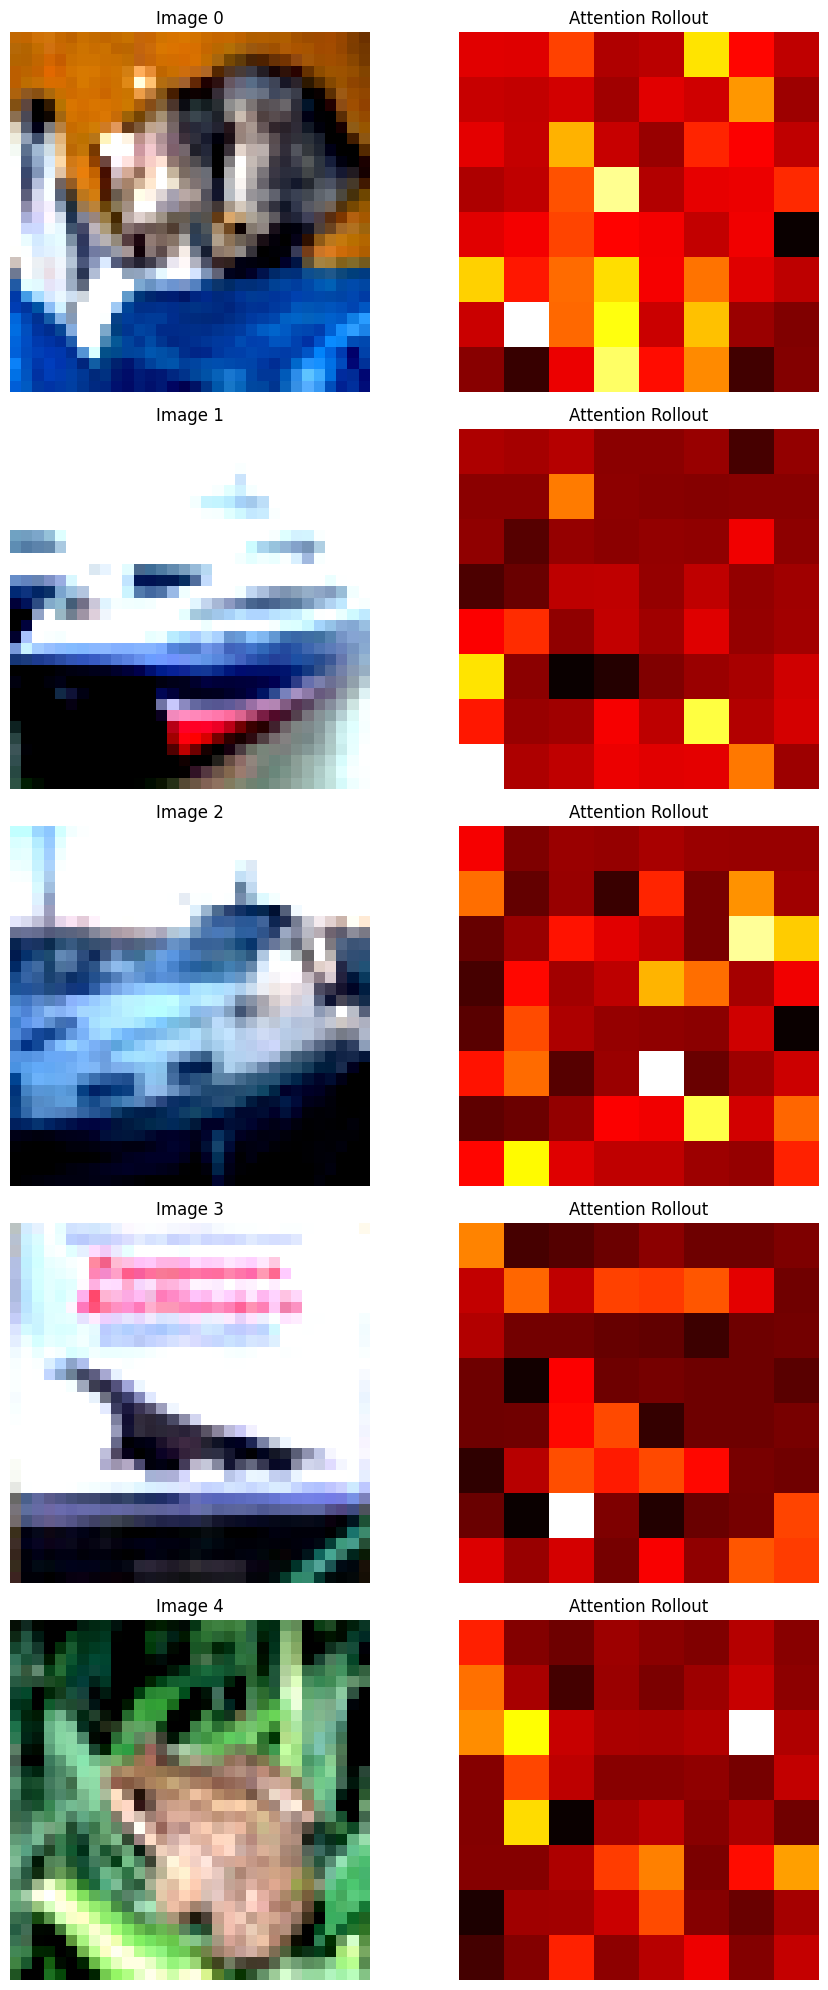

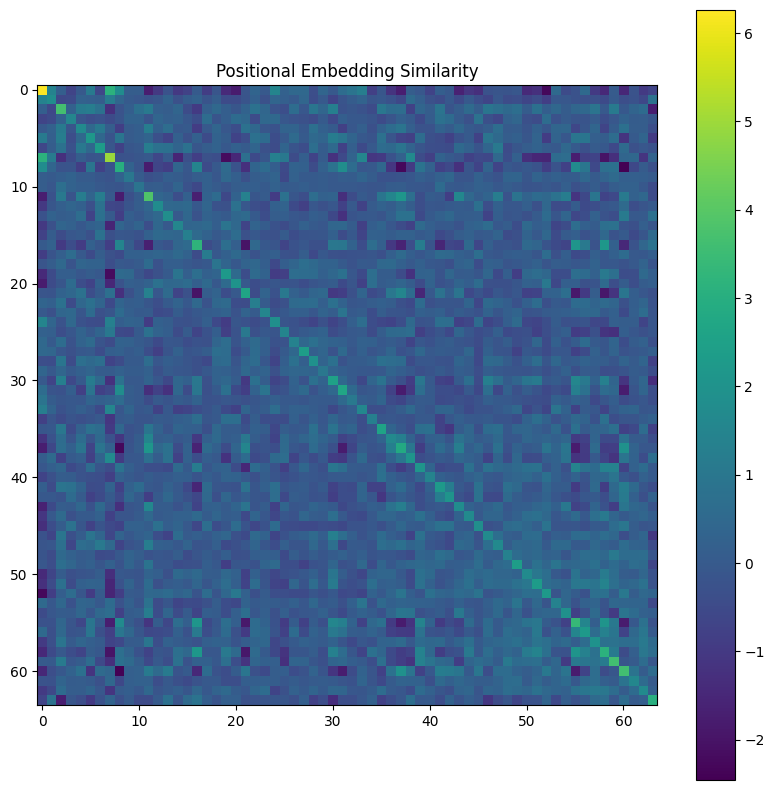

In [11]:
num_epochs = 50
selected_config = configs[1]  

model, history = train_model(selected_config, trainloader, testloader, num_epochs=num_epochs)

torch.save(model.state_dict(), f"results/diff_vit_{selected_config['name']}.pth")

fig = plot_training_history([history], [selected_config['name']], metric='loss')
fig.savefig(f"results/loss_curve_{selected_config['name']}.png")

fig = plot_training_history([history], [selected_config['name']], metric='acc')
fig.savefig(f"results/acc_curve_{selected_config['name']}.png")

fig = visualize_attention_maps(model, testloader, device)
fig.savefig(f"results/attention_maps_{selected_config['name']}.png")

fig = visualize_attention_rollout(model, testloader, device)
fig.savefig(f"results/attention_rollout_{selected_config['name']}.png")

if selected_config['pos_embed_type'] == 'learned_1d':
    fig = visualize_pos_embedding_similarity(model)
    if fig:
        fig.savefig(f"results/pos_embed_similarity_{selected_config['name']}.png")

print("Experiment completed and results saved!")


Training model with configuration: Lambda 0.3


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.89it/s]


Epoch 1/50: Train Loss: 2.0057, Train Acc: 0.2465, Val Loss: 1.8713, Val Acc: 0.2806


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.74it/s]


Epoch 2/50: Train Loss: 1.8781, Train Acc: 0.2882, Val Loss: 1.8725, Val Acc: 0.2989


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.70it/s]


Epoch 3/50: Train Loss: 1.9226, Train Acc: 0.2758, Val Loss: 1.8718, Val Acc: 0.2895


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


Epoch 4/50: Train Loss: 1.8806, Train Acc: 0.2907, Val Loss: 1.8512, Val Acc: 0.3222


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


Epoch 5/50: Train Loss: 1.8312, Train Acc: 0.3155, Val Loss: 1.7679, Val Acc: 0.3500


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.66it/s]


Epoch 6/50: Train Loss: 1.7909, Train Acc: 0.3298, Val Loss: 1.7146, Val Acc: 0.3594


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.49it/s]


Epoch 7/50: Train Loss: 1.7802, Train Acc: 0.3344, Val Loss: 1.7492, Val Acc: 0.3487


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.41it/s]


Epoch 8/50: Train Loss: 1.7268, Train Acc: 0.3584, Val Loss: 1.6411, Val Acc: 0.3843


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.49it/s]


Epoch 9/50: Train Loss: 1.6883, Train Acc: 0.3730, Val Loss: 1.6393, Val Acc: 0.3887


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.62it/s]


Epoch 10/50: Train Loss: 1.6599, Train Acc: 0.3861, Val Loss: 1.6191, Val Acc: 0.4076


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.72it/s]


Epoch 11/50: Train Loss: 1.6402, Train Acc: 0.3946, Val Loss: 1.6315, Val Acc: 0.3908


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.45it/s]


Epoch 12/50: Train Loss: 1.6307, Train Acc: 0.3992, Val Loss: 1.5528, Val Acc: 0.4325


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


Epoch 13/50: Train Loss: 1.6073, Train Acc: 0.4097, Val Loss: 1.6339, Val Acc: 0.4030


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.61it/s]


Epoch 14/50: Train Loss: 1.5822, Train Acc: 0.4183, Val Loss: 1.4867, Val Acc: 0.4492


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


Epoch 15/50: Train Loss: 1.5346, Train Acc: 0.4347, Val Loss: 1.4542, Val Acc: 0.4685


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.54it/s]


Epoch 16/50: Train Loss: 1.5167, Train Acc: 0.4484, Val Loss: 1.4542, Val Acc: 0.4700


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.57it/s]


Epoch 17/50: Train Loss: 1.4828, Train Acc: 0.4591, Val Loss: 1.3836, Val Acc: 0.4885


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.83it/s]


Epoch 18/50: Train Loss: 1.4535, Train Acc: 0.4667, Val Loss: 1.4075, Val Acc: 0.4866


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.40it/s]


Epoch 19/50: Train Loss: 1.4463, Train Acc: 0.4733, Val Loss: 1.3824, Val Acc: 0.4975


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.53it/s]


Epoch 20/50: Train Loss: 1.4147, Train Acc: 0.4839, Val Loss: 1.3246, Val Acc: 0.5180


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.39it/s]


Epoch 21/50: Train Loss: 1.3926, Train Acc: 0.4900, Val Loss: 1.2996, Val Acc: 0.5228


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.41it/s]


Epoch 22/50: Train Loss: 1.3713, Train Acc: 0.4985, Val Loss: 1.3380, Val Acc: 0.5107


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.40it/s]


Epoch 23/50: Train Loss: 1.3466, Train Acc: 0.5108, Val Loss: 1.2592, Val Acc: 0.5391


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


Epoch 24/50: Train Loss: 1.3229, Train Acc: 0.5203, Val Loss: 1.2474, Val Acc: 0.5537


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.51it/s]


Epoch 25/50: Train Loss: 1.3007, Train Acc: 0.5288, Val Loss: 1.2304, Val Acc: 0.5488


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.42it/s]


Epoch 26/50: Train Loss: 1.2831, Train Acc: 0.5356, Val Loss: 1.2475, Val Acc: 0.5475


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.66it/s]


Epoch 27/50: Train Loss: 1.2620, Train Acc: 0.5421, Val Loss: 1.1913, Val Acc: 0.5692


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.36it/s]


Epoch 28/50: Train Loss: 1.2380, Train Acc: 0.5538, Val Loss: 1.1882, Val Acc: 0.5707


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.15it/s]


Epoch 29/50: Train Loss: 1.2229, Train Acc: 0.5552, Val Loss: 1.1601, Val Acc: 0.5769


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.44it/s]


Epoch 30/50: Train Loss: 1.1938, Train Acc: 0.5680, Val Loss: 1.1831, Val Acc: 0.5778


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.17it/s]


Epoch 31/50: Train Loss: 1.1844, Train Acc: 0.5731, Val Loss: 1.1625, Val Acc: 0.5857


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.49it/s]


Epoch 32/50: Train Loss: 1.1619, Train Acc: 0.5812, Val Loss: 1.1209, Val Acc: 0.5975


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.99it/s]


Epoch 33/50: Train Loss: 1.1444, Train Acc: 0.5864, Val Loss: 1.1129, Val Acc: 0.6006


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.61it/s]


Epoch 34/50: Train Loss: 1.1194, Train Acc: 0.5945, Val Loss: 1.0921, Val Acc: 0.6083


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.93it/s]


Epoch 35/50: Train Loss: 1.1147, Train Acc: 0.5980, Val Loss: 1.0814, Val Acc: 0.6090


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.09it/s]


Epoch 36/50: Train Loss: 1.0955, Train Acc: 0.6050, Val Loss: 1.0639, Val Acc: 0.6218


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.61it/s]


Epoch 37/50: Train Loss: 1.0799, Train Acc: 0.6101, Val Loss: 1.0576, Val Acc: 0.6232


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


Epoch 38/50: Train Loss: 1.0695, Train Acc: 0.6135, Val Loss: 1.0553, Val Acc: 0.6237


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.40it/s]


Epoch 39/50: Train Loss: 1.0500, Train Acc: 0.6230, Val Loss: 1.0346, Val Acc: 0.6320


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.49it/s]


Epoch 40/50: Train Loss: 1.0386, Train Acc: 0.6264, Val Loss: 1.0269, Val Acc: 0.6343


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.62it/s]


Epoch 41/50: Train Loss: 1.0258, Train Acc: 0.6303, Val Loss: 1.0311, Val Acc: 0.6314


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.59it/s]


Epoch 42/50: Train Loss: 1.0118, Train Acc: 0.6345, Val Loss: 1.0132, Val Acc: 0.6389


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


Epoch 43/50: Train Loss: 1.0038, Train Acc: 0.6404, Val Loss: 1.0132, Val Acc: 0.6389


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.94it/s]


Epoch 44/50: Train Loss: 0.9910, Train Acc: 0.6431, Val Loss: 1.0145, Val Acc: 0.6385


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.44it/s]


Epoch 45/50: Train Loss: 0.9917, Train Acc: 0.6448, Val Loss: 1.0018, Val Acc: 0.6455


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.32it/s]


Epoch 46/50: Train Loss: 0.9849, Train Acc: 0.6454, Val Loss: 1.0083, Val Acc: 0.6438


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.59it/s]


Epoch 47/50: Train Loss: 0.9798, Train Acc: 0.6449, Val Loss: 1.0063, Val Acc: 0.6430


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.42it/s]


Epoch 48/50: Train Loss: 0.9783, Train Acc: 0.6475, Val Loss: 1.0034, Val Acc: 0.6449


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.67it/s]


Epoch 49/50: Train Loss: 0.9747, Train Acc: 0.6489, Val Loss: 1.0015, Val Acc: 0.6455


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.38it/s]


Epoch 50/50: Train Loss: 0.9700, Train Acc: 0.6516, Val Loss: 1.0022, Val Acc: 0.6445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.4979501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4629833..1.5354269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22441113..1.4005105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4391681..1.2814069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49

Experiment completed and results saved!


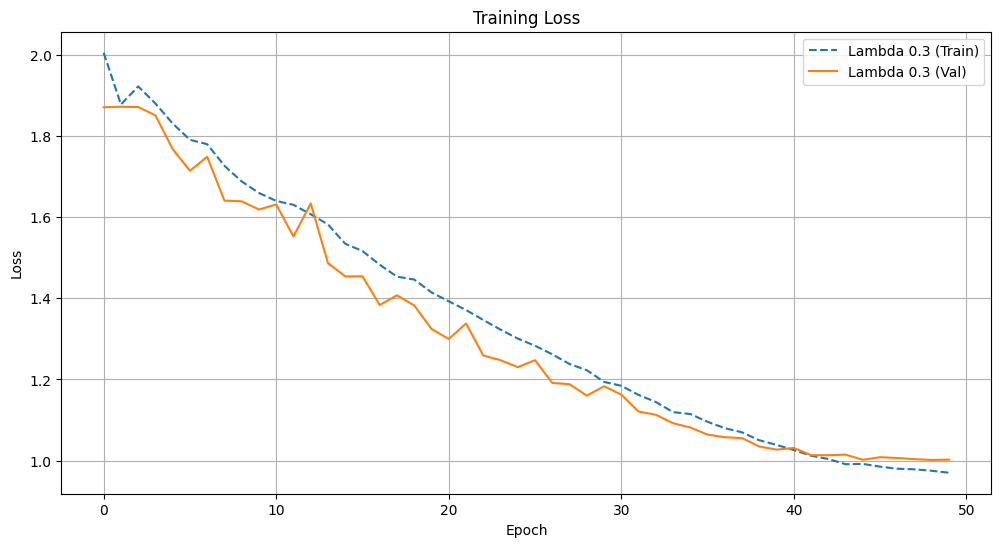

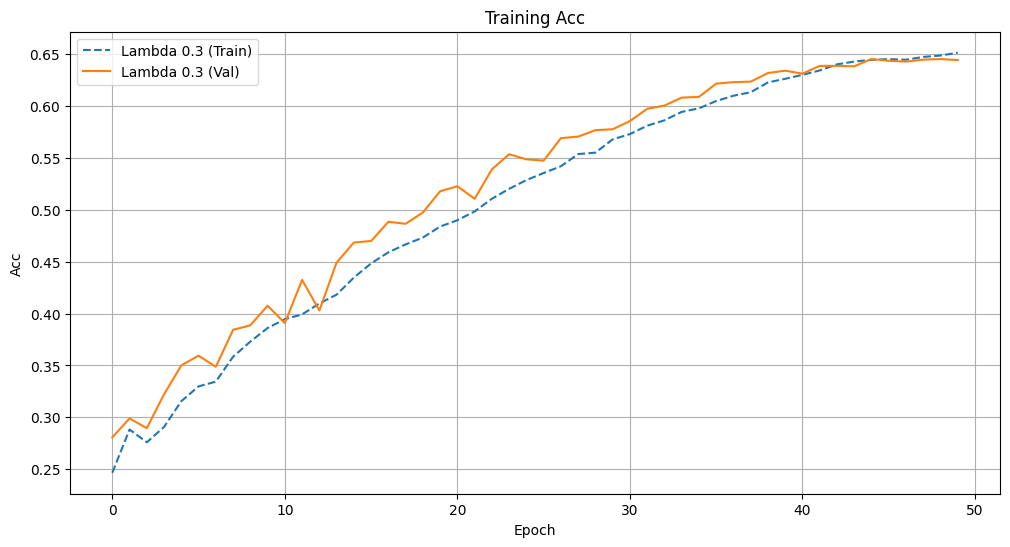

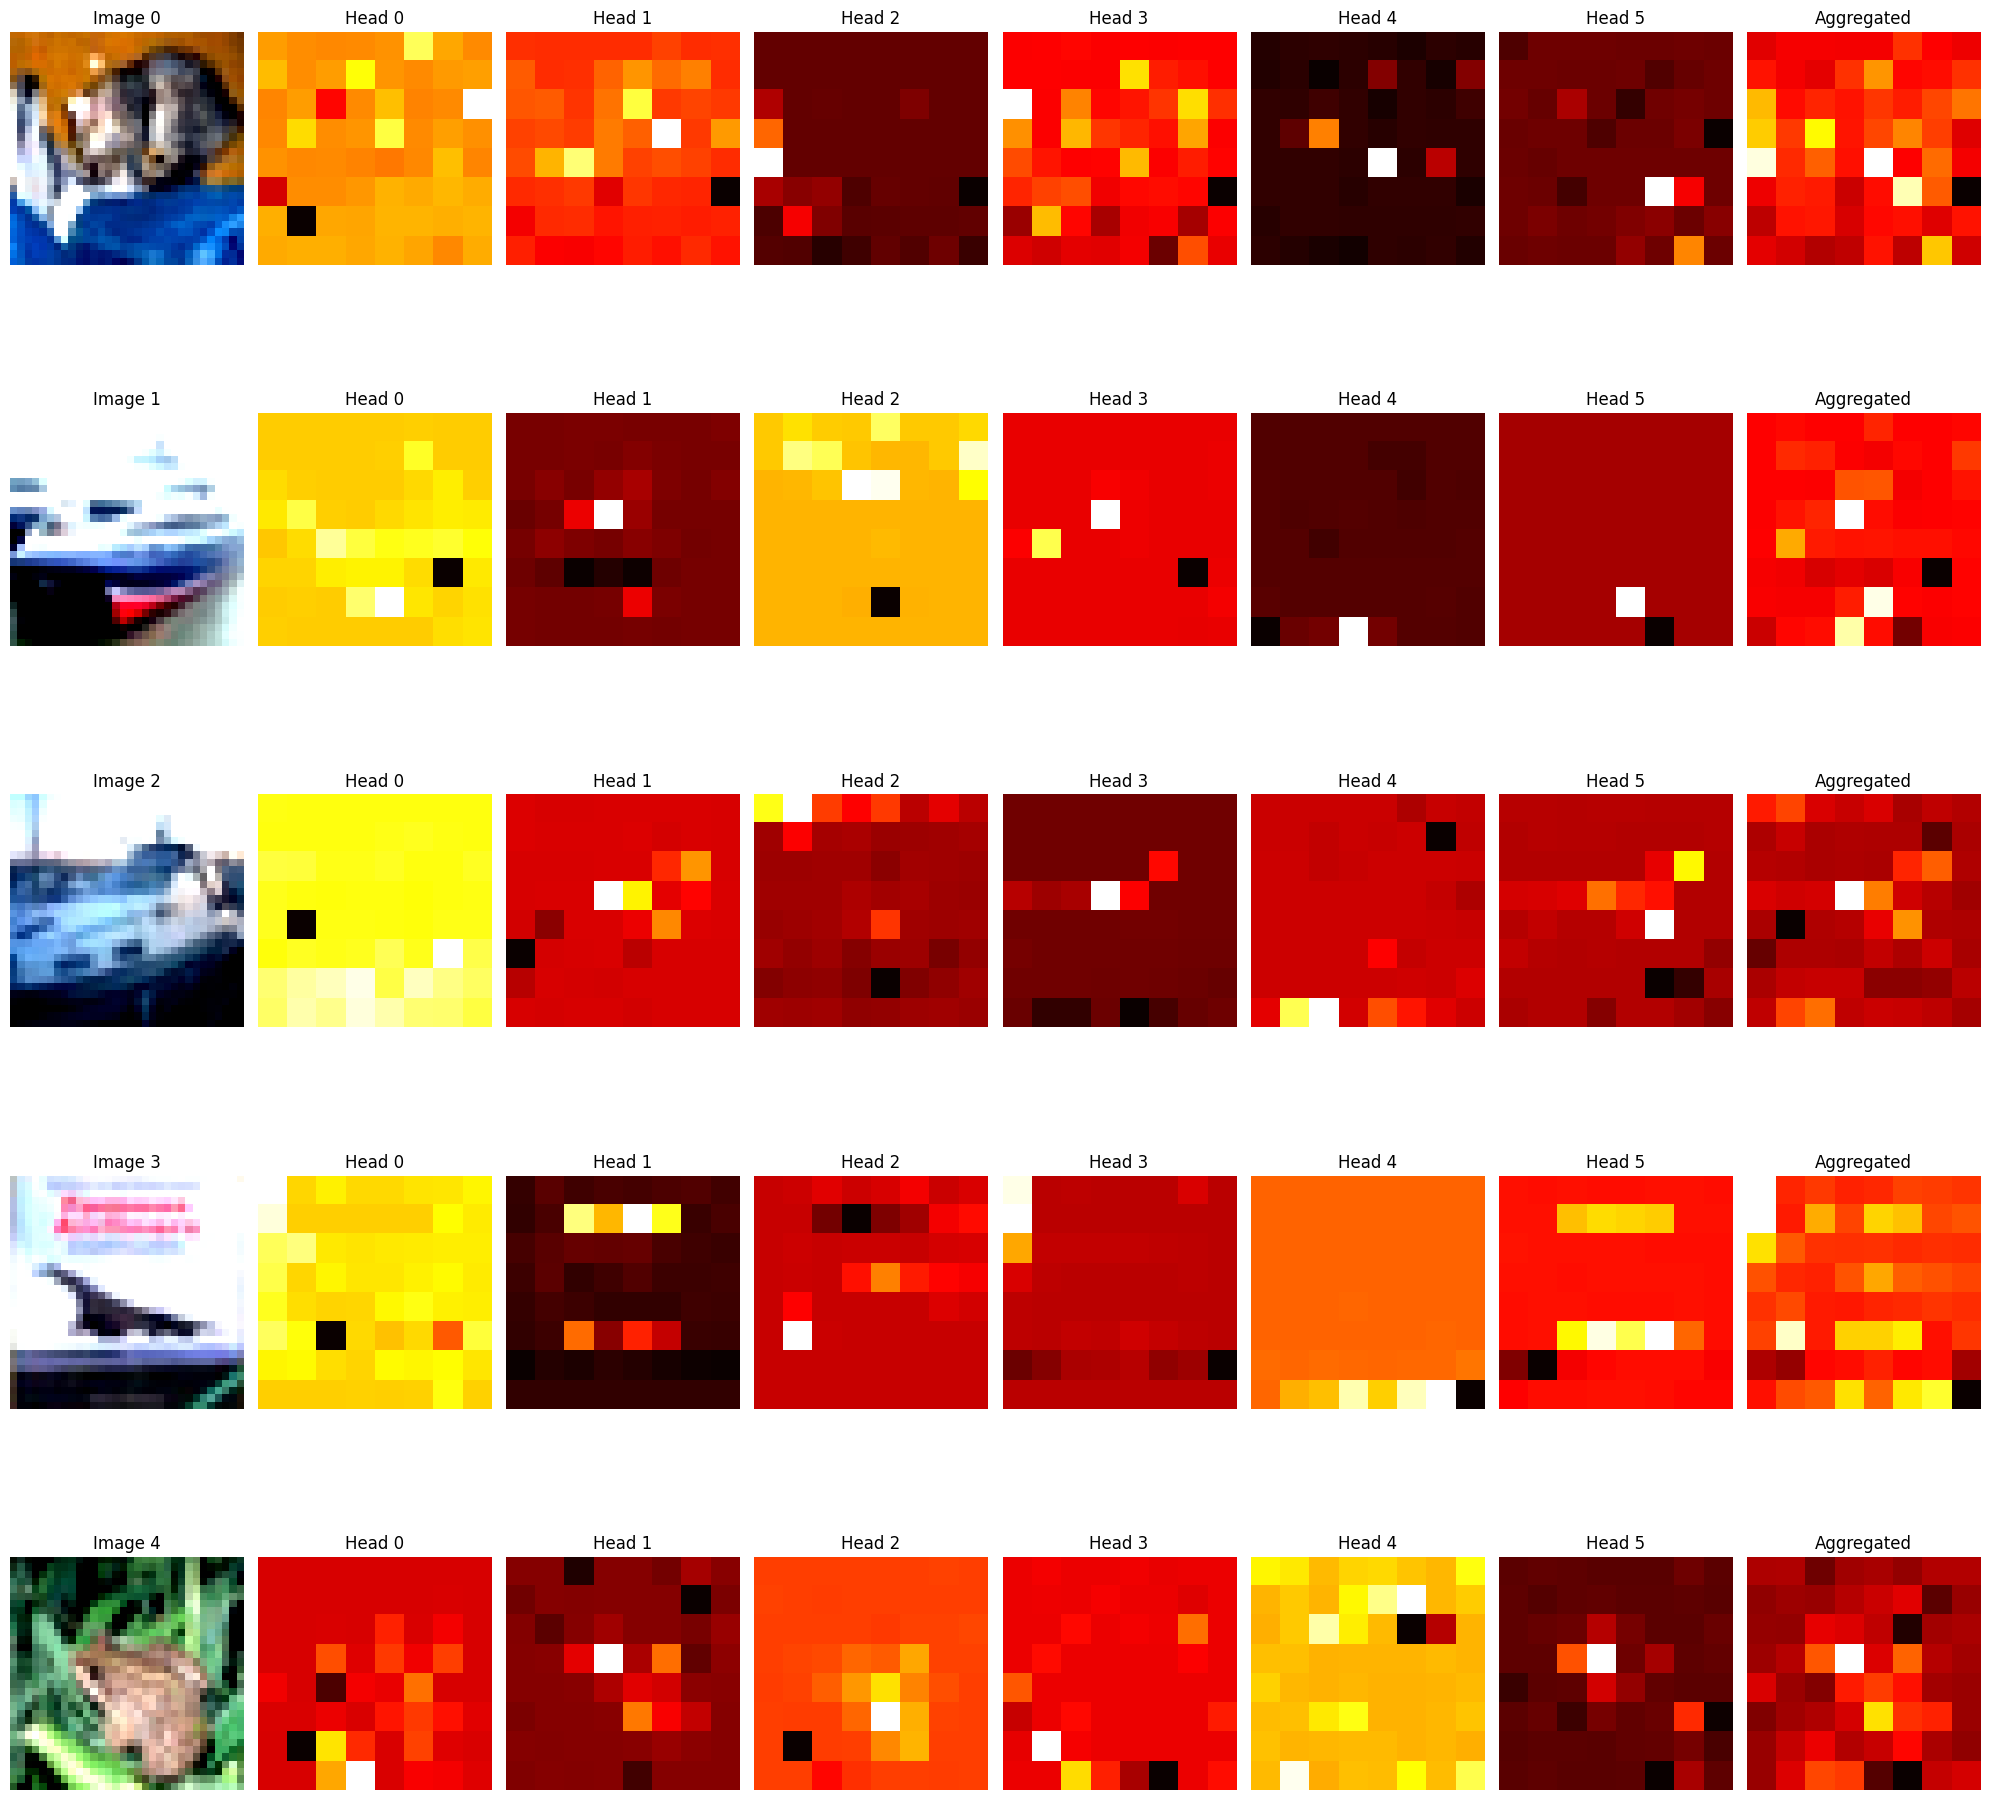

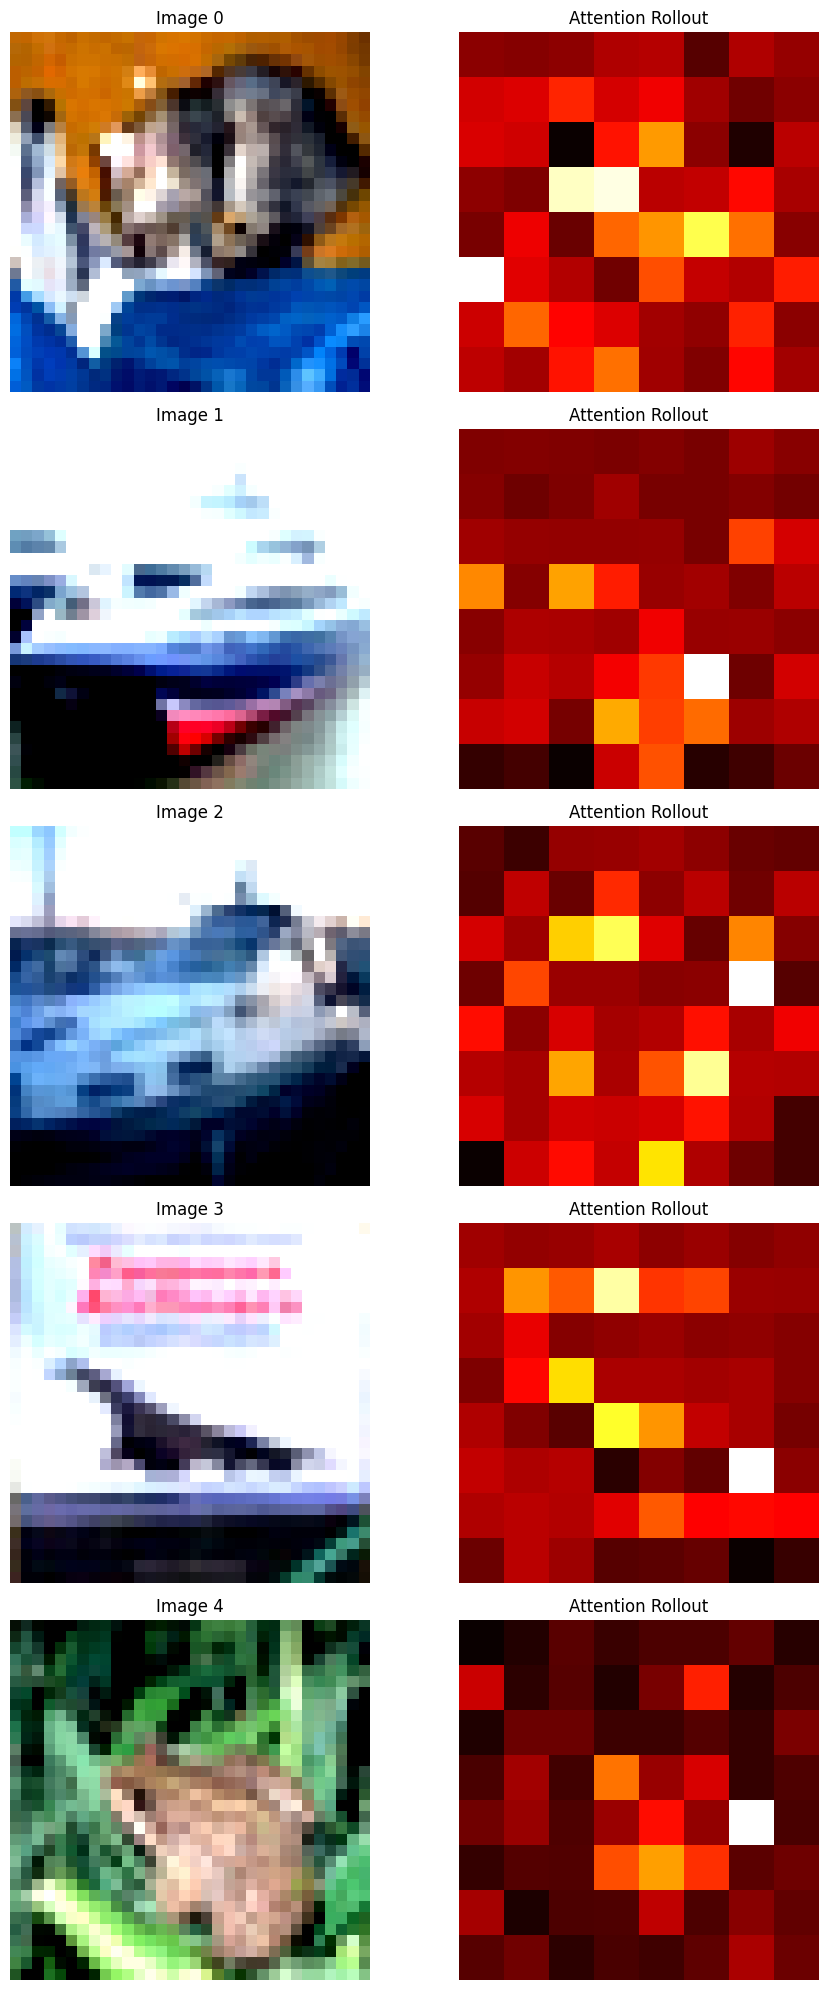

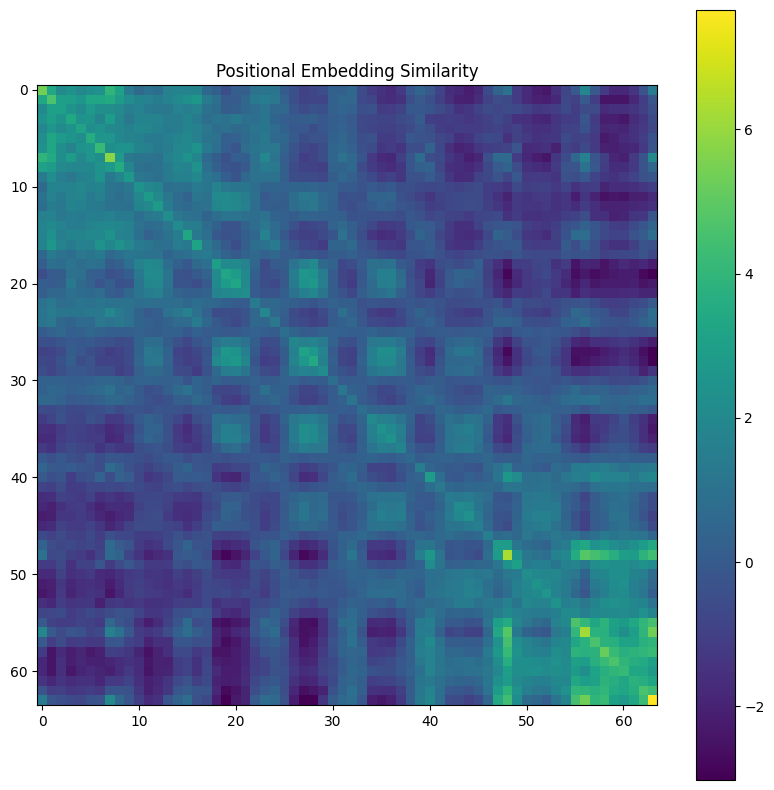

In [13]:
num_epochs = 50
selected_config = configs[2]  

model, history = train_model(selected_config, trainloader, testloader, num_epochs=num_epochs)

torch.save(model.state_dict(), f"results/diff_vit_{selected_config['name']}.pth")

fig = plot_training_history([history], [selected_config['name']], metric='loss')
fig.savefig(f"results/loss_curve_{selected_config['name']}.png")

fig = plot_training_history([history], [selected_config['name']], metric='acc')
fig.savefig(f"results/acc_curve_{selected_config['name']}.png")

fig = visualize_attention_maps(model, testloader, device)
fig.savefig(f"results/attention_maps_{selected_config['name']}.png")

fig = visualize_attention_rollout(model, testloader, device)
fig.savefig(f"results/attention_rollout_{selected_config['name']}.png")

if selected_config['pos_embed_type'] == 'learned_1d':
    fig = visualize_pos_embedding_similarity(model)
    if fig:
        fig.savefig(f"results/pos_embed_similarity_{selected_config['name']}.png")

print("Experiment completed and results saved!")


Training model with configuration: No Pos Embedding


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.17it/s]


Epoch 1/50: Train Loss: 2.1060, Train Acc: 0.2039, Val Loss: 2.0175, Val Acc: 0.2346


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.91it/s]


Epoch 2/50: Train Loss: 1.9126, Train Acc: 0.2738, Val Loss: 1.8581, Val Acc: 0.3038


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.76it/s]


Epoch 3/50: Train Loss: 1.8211, Train Acc: 0.3123, Val Loss: 1.7760, Val Acc: 0.3339


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.69it/s]


Epoch 4/50: Train Loss: 1.7631, Train Acc: 0.3383, Val Loss: 1.7004, Val Acc: 0.3666


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.51it/s]


Epoch 5/50: Train Loss: 1.7210, Train Acc: 0.3583, Val Loss: 1.6577, Val Acc: 0.3827


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.60it/s]


Epoch 6/50: Train Loss: 1.6827, Train Acc: 0.3745, Val Loss: 1.6310, Val Acc: 0.3895


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.65it/s]


Epoch 7/50: Train Loss: 1.6565, Train Acc: 0.3845, Val Loss: 1.6433, Val Acc: 0.3924


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.87it/s]


Epoch 8/50: Train Loss: 1.6255, Train Acc: 0.4005, Val Loss: 1.6150, Val Acc: 0.4011


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.48it/s]


Epoch 9/50: Train Loss: 1.5975, Train Acc: 0.4101, Val Loss: 1.5923, Val Acc: 0.4117


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.42it/s]


Epoch 10/50: Train Loss: 1.5810, Train Acc: 0.4179, Val Loss: 1.5433, Val Acc: 0.4371


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


Epoch 11/50: Train Loss: 1.5556, Train Acc: 0.4298, Val Loss: 1.5219, Val Acc: 0.4474


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.05it/s]


Epoch 12/50: Train Loss: 1.5346, Train Acc: 0.4366, Val Loss: 1.5642, Val Acc: 0.4253


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.55it/s]


Epoch 13/50: Train Loss: 1.5043, Train Acc: 0.4493, Val Loss: 1.5298, Val Acc: 0.4348


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


Epoch 14/50: Train Loss: 1.4881, Train Acc: 0.4538, Val Loss: 1.5073, Val Acc: 0.4456


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.73it/s]


Epoch 15/50: Train Loss: 1.4698, Train Acc: 0.4653, Val Loss: 1.4590, Val Acc: 0.4631


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.33it/s]


Epoch 16/50: Train Loss: 1.4418, Train Acc: 0.4755, Val Loss: 1.4921, Val Acc: 0.4538


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.30it/s]


Epoch 17/50: Train Loss: 1.4238, Train Acc: 0.4818, Val Loss: 1.4546, Val Acc: 0.4647


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.47it/s]


Epoch 18/50: Train Loss: 1.4077, Train Acc: 0.4857, Val Loss: 1.4513, Val Acc: 0.4731


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.96it/s]


Epoch 19/50: Train Loss: 1.3910, Train Acc: 0.4946, Val Loss: 1.3890, Val Acc: 0.4968


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.55it/s]


Epoch 20/50: Train Loss: 1.3664, Train Acc: 0.5041, Val Loss: 1.3729, Val Acc: 0.4985


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.48it/s]


Epoch 21/50: Train Loss: 1.3557, Train Acc: 0.5078, Val Loss: 1.3768, Val Acc: 0.5036


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.68it/s]


Epoch 22/50: Train Loss: 1.3315, Train Acc: 0.5175, Val Loss: 1.3401, Val Acc: 0.5118


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.58it/s]


Epoch 23/50: Train Loss: 1.3060, Train Acc: 0.5249, Val Loss: 1.3482, Val Acc: 0.5105


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.62it/s]


Epoch 24/50: Train Loss: 1.2821, Train Acc: 0.5345, Val Loss: 1.3088, Val Acc: 0.5237


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.43it/s]


Epoch 25/50: Train Loss: 1.2628, Train Acc: 0.5431, Val Loss: 1.3285, Val Acc: 0.5300


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.77it/s]


Epoch 26/50: Train Loss: 1.2460, Train Acc: 0.5475, Val Loss: 1.2735, Val Acc: 0.5434


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.35it/s]


Epoch 27/50: Train Loss: 1.2241, Train Acc: 0.5578, Val Loss: 1.2559, Val Acc: 0.5517


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


Epoch 28/50: Train Loss: 1.2060, Train Acc: 0.5640, Val Loss: 1.2684, Val Acc: 0.5440


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.48it/s]


Epoch 29/50: Train Loss: 1.1819, Train Acc: 0.5726, Val Loss: 1.2315, Val Acc: 0.5545


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.48it/s]


Epoch 30/50: Train Loss: 1.1647, Train Acc: 0.5815, Val Loss: 1.2317, Val Acc: 0.5557


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.52it/s]


Epoch 31/50: Train Loss: 1.1369, Train Acc: 0.5904, Val Loss: 1.2252, Val Acc: 0.5630


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.54it/s]


Epoch 32/50: Train Loss: 1.1226, Train Acc: 0.5963, Val Loss: 1.1956, Val Acc: 0.5730


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.74it/s]


Epoch 33/50: Train Loss: 1.1001, Train Acc: 0.6006, Val Loss: 1.2050, Val Acc: 0.5692


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.43it/s]


Epoch 34/50: Train Loss: 1.0858, Train Acc: 0.6065, Val Loss: 1.2023, Val Acc: 0.5719


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.53it/s]


Epoch 35/50: Train Loss: 1.0645, Train Acc: 0.6170, Val Loss: 1.1876, Val Acc: 0.5792


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.45it/s]


Epoch 36/50: Train Loss: 1.0478, Train Acc: 0.6242, Val Loss: 1.1687, Val Acc: 0.5834


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.87it/s]


Epoch 37/50: Train Loss: 1.0330, Train Acc: 0.6291, Val Loss: 1.1622, Val Acc: 0.5889


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.34it/s]


Epoch 38/50: Train Loss: 1.0178, Train Acc: 0.6318, Val Loss: 1.1522, Val Acc: 0.5909


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.44it/s]


Epoch 39/50: Train Loss: 1.0017, Train Acc: 0.6411, Val Loss: 1.1328, Val Acc: 0.5976


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.18it/s]


Epoch 40/50: Train Loss: 0.9851, Train Acc: 0.6466, Val Loss: 1.1404, Val Acc: 0.6000


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.06it/s]


Epoch 41/50: Train Loss: 0.9662, Train Acc: 0.6514, Val Loss: 1.1359, Val Acc: 0.5993


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.80it/s]


Epoch 42/50: Train Loss: 0.9616, Train Acc: 0.6564, Val Loss: 1.1356, Val Acc: 0.6005


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.27it/s]


Epoch 43/50: Train Loss: 0.9501, Train Acc: 0.6573, Val Loss: 1.1343, Val Acc: 0.6039


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.58it/s]


Epoch 44/50: Train Loss: 0.9391, Train Acc: 0.6615, Val Loss: 1.1334, Val Acc: 0.6010


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.38it/s]


Epoch 45/50: Train Loss: 0.9340, Train Acc: 0.6629, Val Loss: 1.1258, Val Acc: 0.6050


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.57it/s]


Epoch 46/50: Train Loss: 0.9254, Train Acc: 0.6675, Val Loss: 1.1193, Val Acc: 0.6069


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.26it/s]


Epoch 47/50: Train Loss: 0.9269, Train Acc: 0.6693, Val Loss: 1.1181, Val Acc: 0.6076


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.31it/s]


Epoch 48/50: Train Loss: 0.9191, Train Acc: 0.6699, Val Loss: 1.1173, Val Acc: 0.6090


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.68it/s]


Epoch 49/50: Train Loss: 0.9147, Train Acc: 0.6717, Val Loss: 1.1199, Val Acc: 0.6074


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


Epoch 50/50: Train Loss: 0.9138, Train Acc: 0.6709, Val Loss: 1.1203, Val Acc: 0.6074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.4979501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4629833..1.5354269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22441113..1.4005105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4391681..1.2814069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49

Experiment completed and results saved!


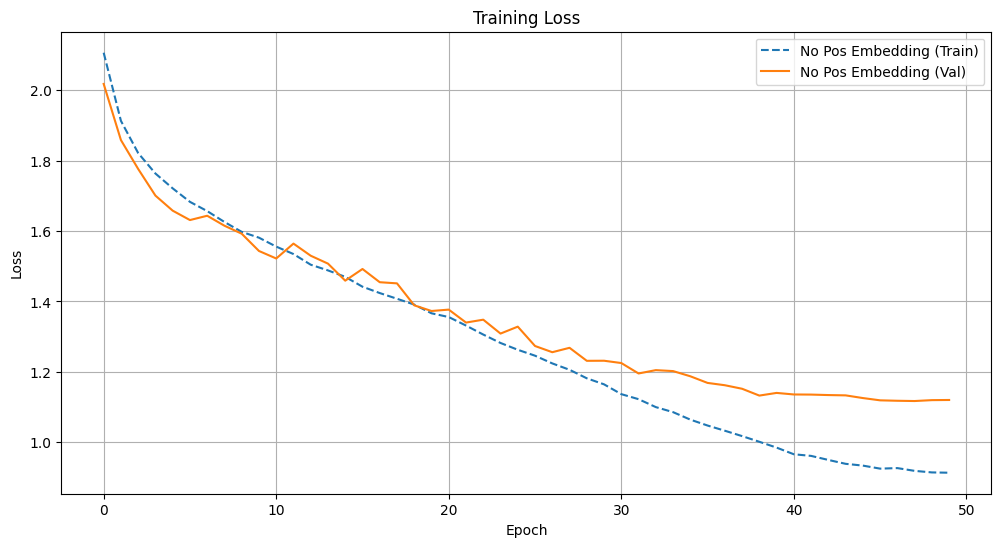

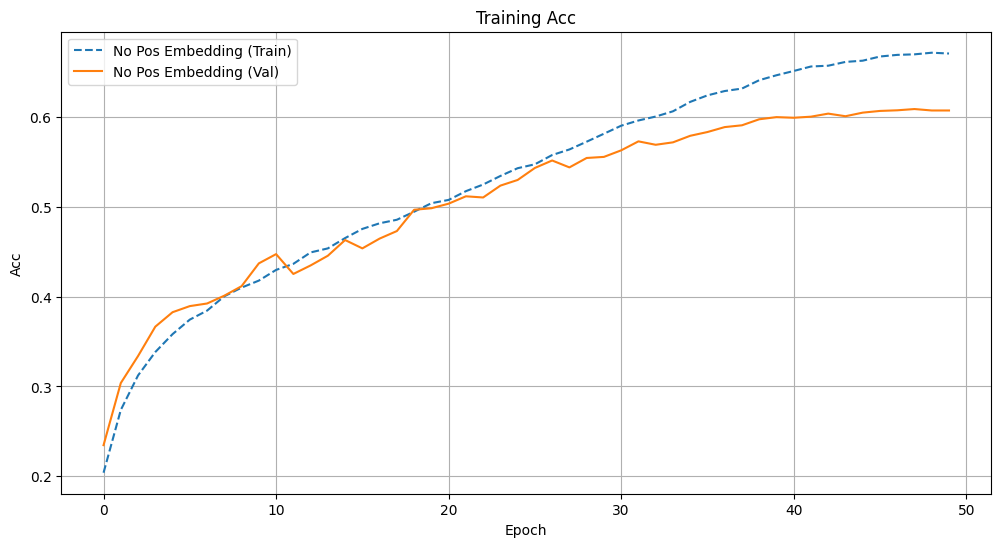

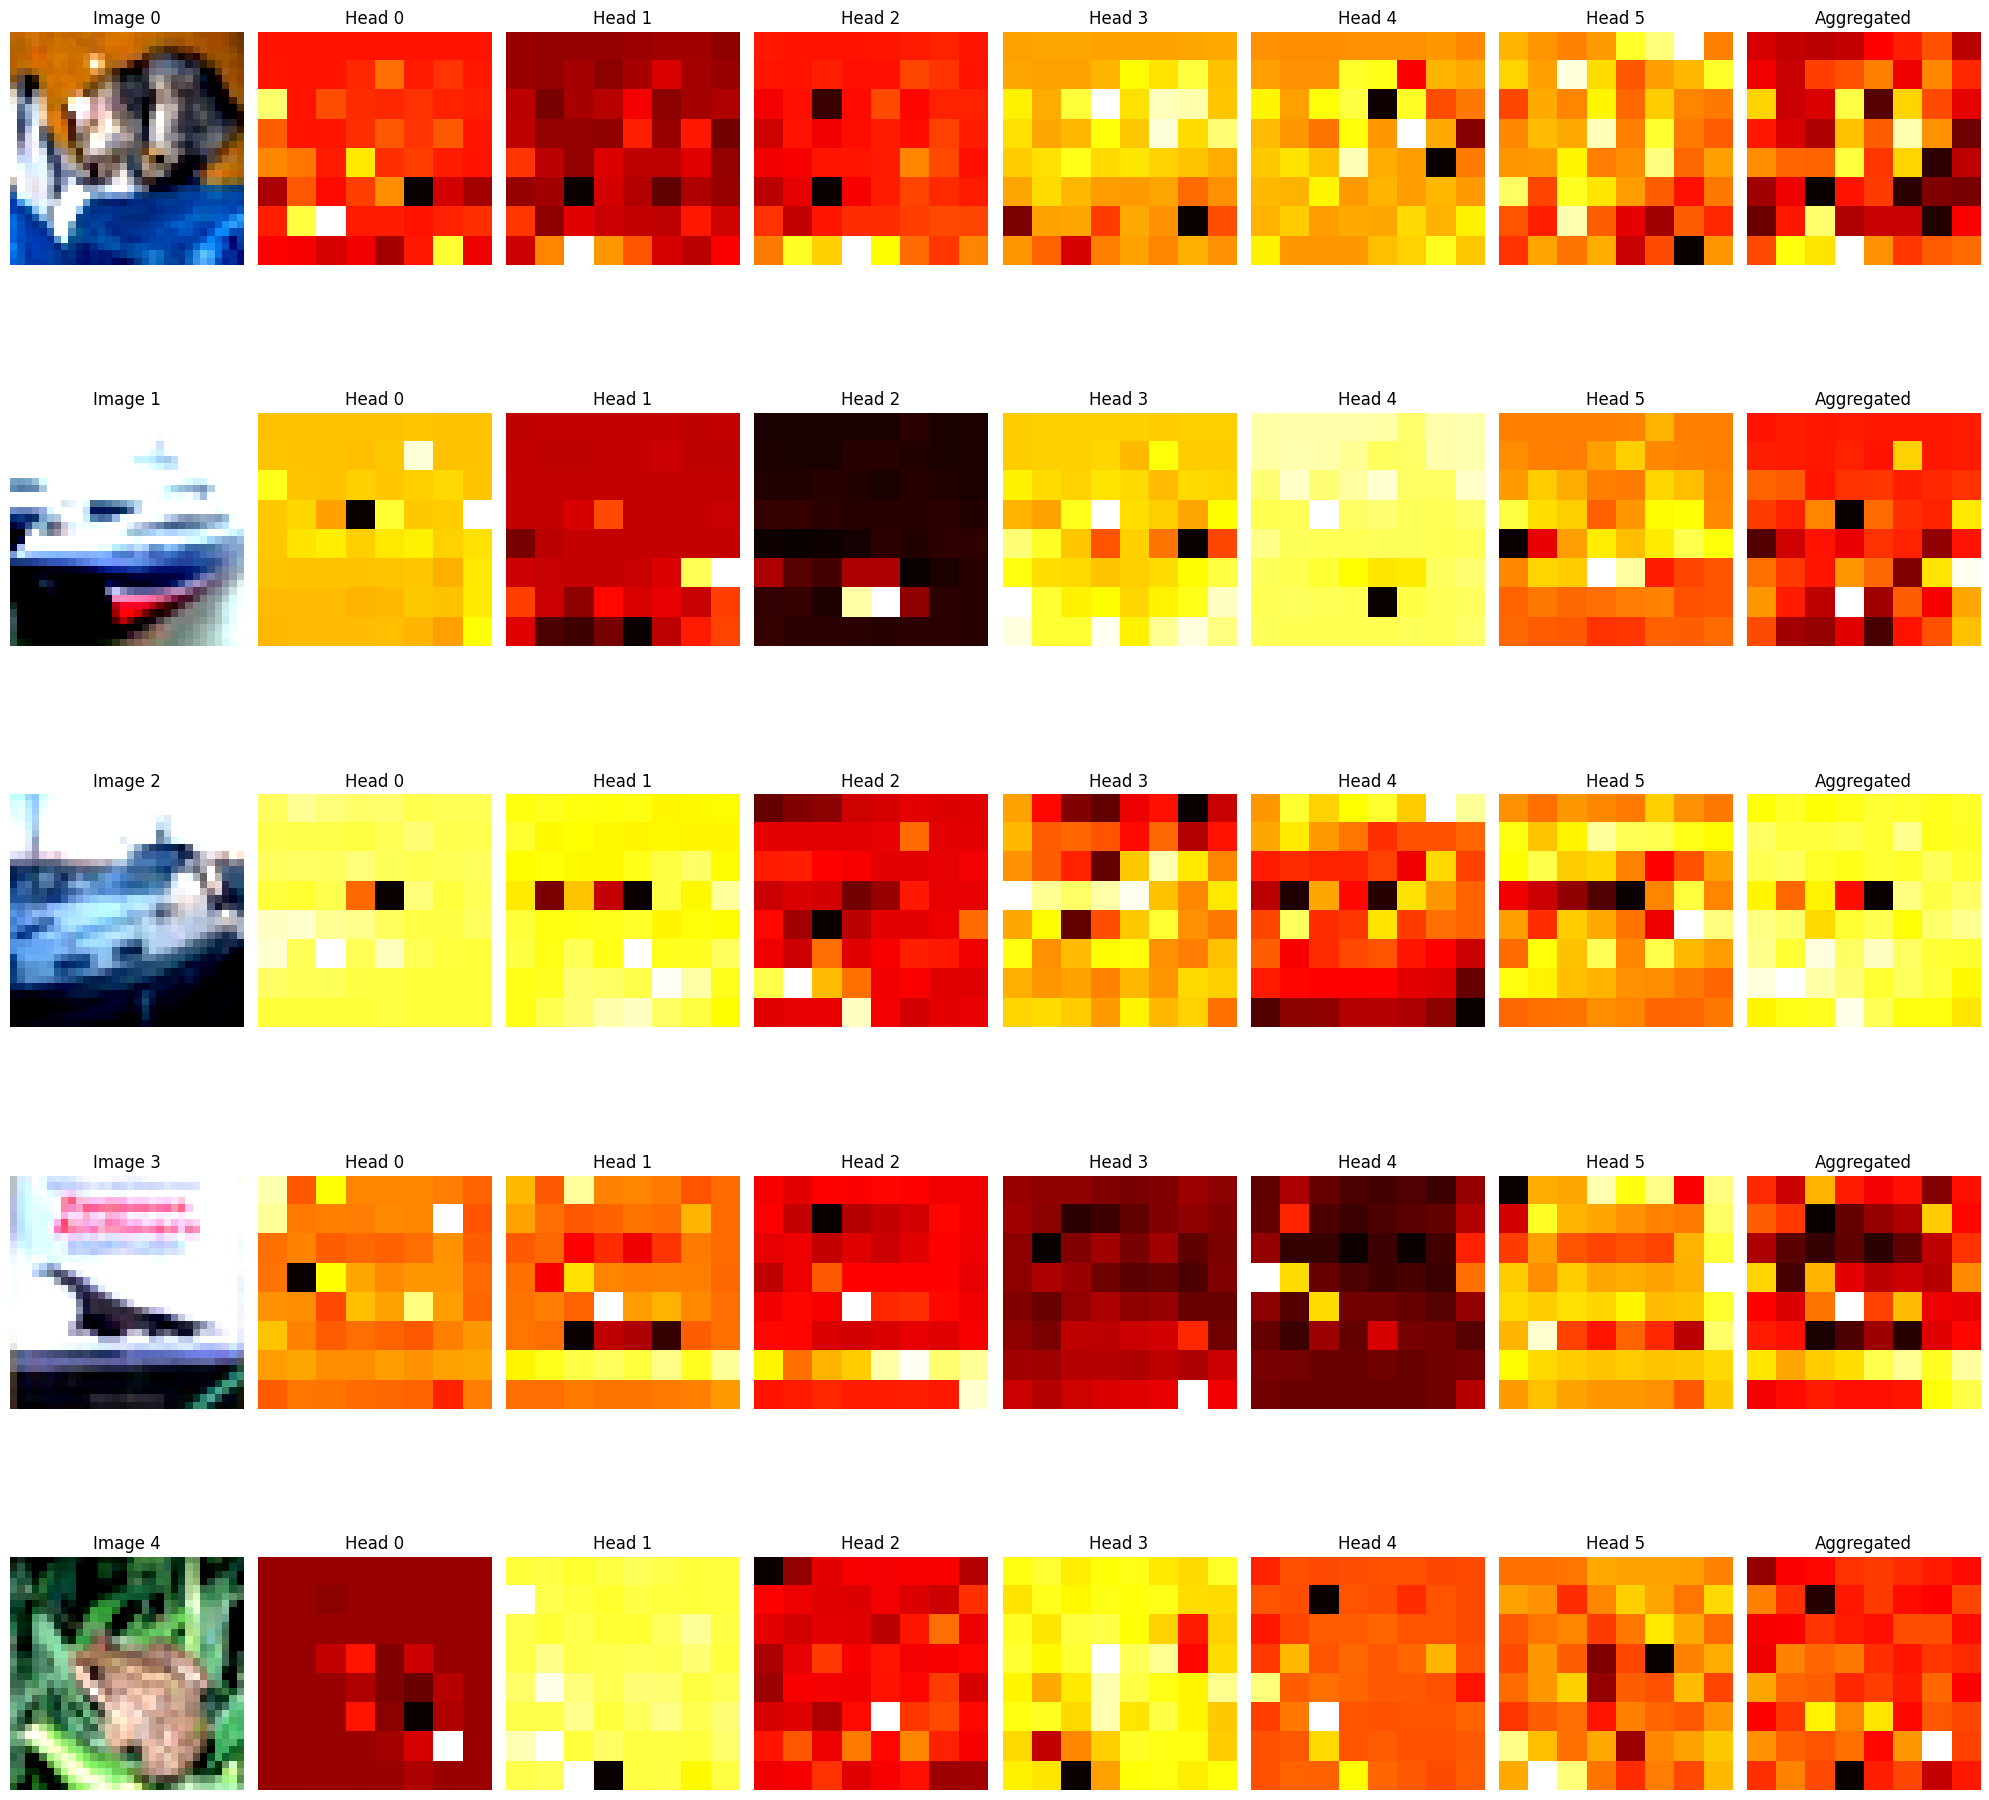

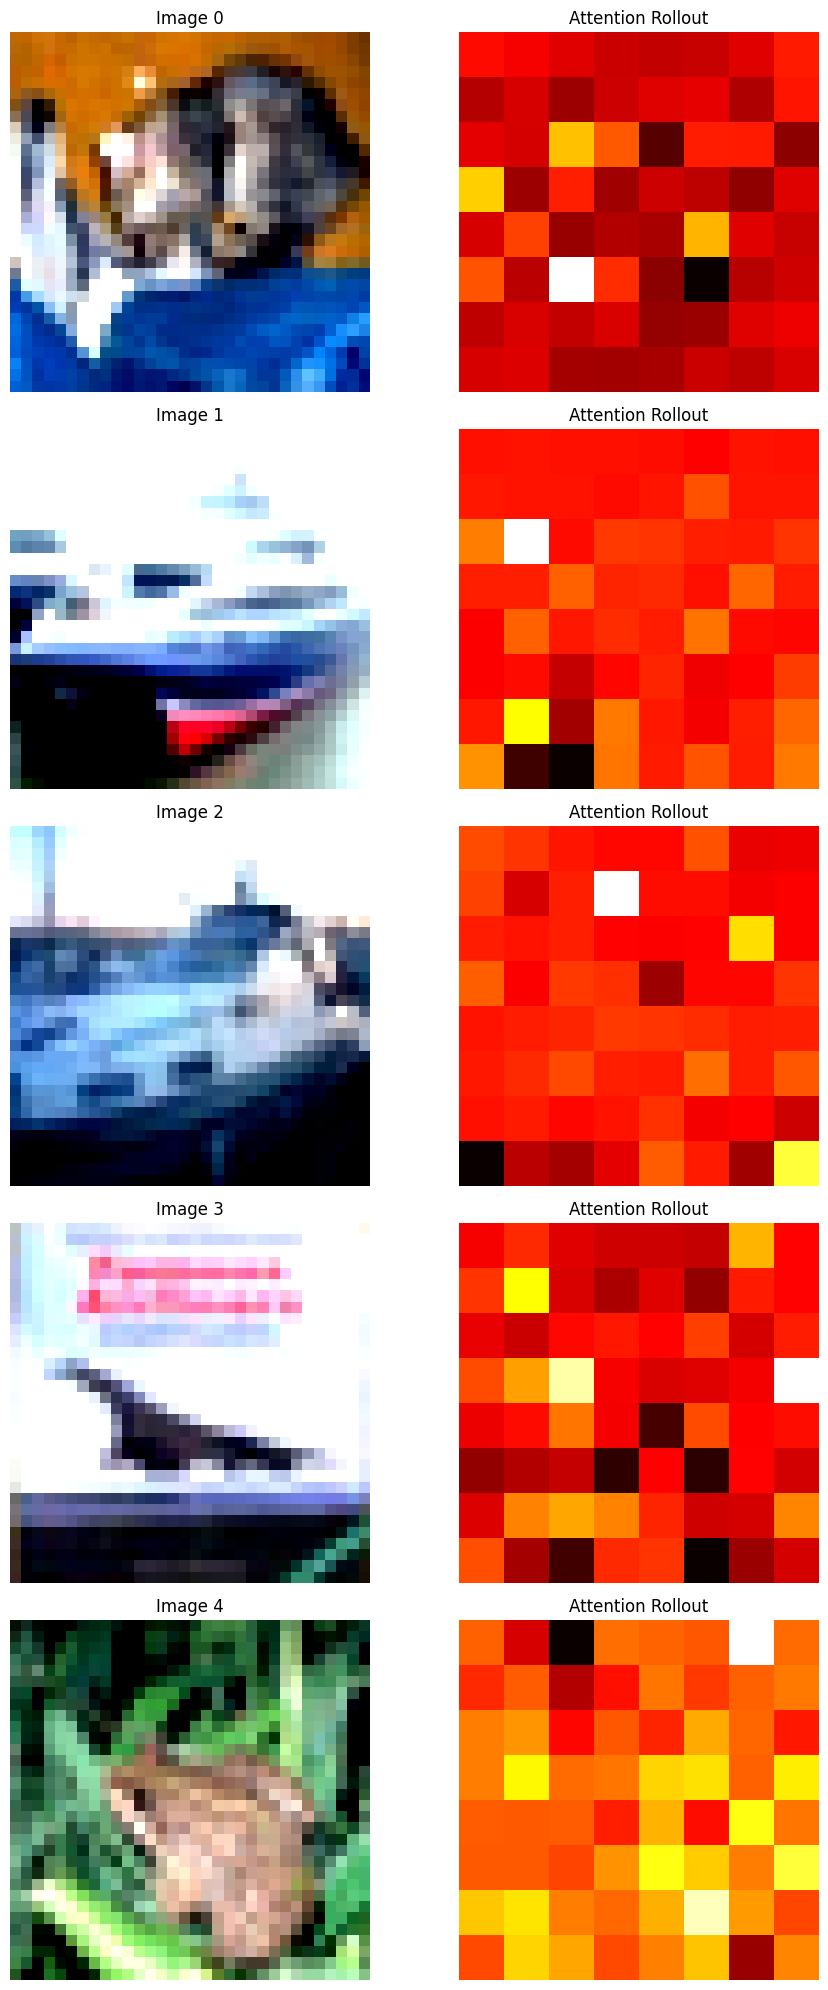

In [14]:
num_epochs = 50
selected_config = configs[3]  

model, history = train_model(selected_config, trainloader, testloader, num_epochs=num_epochs)

torch.save(model.state_dict(), f"results/diff_vit_{selected_config['name']}.pth")

fig = plot_training_history([history], [selected_config['name']], metric='loss')
fig.savefig(f"results/loss_curve_{selected_config['name']}.png")

fig = plot_training_history([history], [selected_config['name']], metric='acc')
fig.savefig(f"results/acc_curve_{selected_config['name']}.png")

fig = visualize_attention_maps(model, testloader, device)
fig.savefig(f"results/attention_maps_{selected_config['name']}.png")

fig = visualize_attention_rollout(model, testloader, device)
fig.savefig(f"results/attention_rollout_{selected_config['name']}.png")

if selected_config['pos_embed_type'] == 'learned_1d':
    fig = visualize_pos_embedding_similarity(model)
    if fig:
        fig.savefig(f"results/pos_embed_similarity_{selected_config['name']}.png")

print("Experiment completed and results saved!")


Training model with configuration: Sinusoidal


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.10it/s]


Epoch 1/50: Train Loss: 2.0232, Train Acc: 0.2426, Val Loss: 1.8296, Val Acc: 0.3207


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


Epoch 2/50: Train Loss: 1.8168, Train Acc: 0.3304, Val Loss: 1.7897, Val Acc: 0.3440


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.55it/s]


Epoch 3/50: Train Loss: 1.7732, Train Acc: 0.3462, Val Loss: 1.6918, Val Acc: 0.3797


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.22it/s]


Epoch 4/50: Train Loss: 1.7596, Train Acc: 0.3531, Val Loss: 1.6669, Val Acc: 0.3943


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.52it/s]


Epoch 5/50: Train Loss: 1.7263, Train Acc: 0.3701, Val Loss: 1.6156, Val Acc: 0.4222


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.38it/s]


Epoch 6/50: Train Loss: 1.6933, Train Acc: 0.3815, Val Loss: 1.5808, Val Acc: 0.4319


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.36it/s]


Epoch 7/50: Train Loss: 1.6634, Train Acc: 0.3917, Val Loss: 1.5417, Val Acc: 0.4500


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


Epoch 8/50: Train Loss: 1.6532, Train Acc: 0.3945, Val Loss: 1.5849, Val Acc: 0.4299


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


Epoch 9/50: Train Loss: 1.6301, Train Acc: 0.4042, Val Loss: 1.5327, Val Acc: 0.4489


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.41it/s]


Epoch 10/50: Train Loss: 1.6071, Train Acc: 0.4137, Val Loss: 1.5289, Val Acc: 0.4466


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.34it/s]


Epoch 11/50: Train Loss: 1.5897, Train Acc: 0.4199, Val Loss: 1.4710, Val Acc: 0.4730


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.80it/s]


Epoch 12/50: Train Loss: 1.5605, Train Acc: 0.4321, Val Loss: 1.4539, Val Acc: 0.4752


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.50it/s]


Epoch 13/50: Train Loss: 1.5411, Train Acc: 0.4385, Val Loss: 1.4624, Val Acc: 0.4790


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.66it/s]


Epoch 14/50: Train Loss: 1.5203, Train Acc: 0.4488, Val Loss: 1.4286, Val Acc: 0.4855


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.42it/s]


Epoch 15/50: Train Loss: 1.5141, Train Acc: 0.4490, Val Loss: 1.4147, Val Acc: 0.4897


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.49it/s]


Epoch 16/50: Train Loss: 1.4871, Train Acc: 0.4584, Val Loss: 1.4070, Val Acc: 0.4902


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.33it/s]


Epoch 17/50: Train Loss: 1.4745, Train Acc: 0.4612, Val Loss: 1.3830, Val Acc: 0.5042


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.72it/s]


Epoch 18/50: Train Loss: 1.4568, Train Acc: 0.4685, Val Loss: 1.3868, Val Acc: 0.5106


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.50it/s]


Epoch 19/50: Train Loss: 1.4399, Train Acc: 0.4761, Val Loss: 1.3717, Val Acc: 0.5040


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.99it/s]


Epoch 20/50: Train Loss: 1.4233, Train Acc: 0.4866, Val Loss: 1.3302, Val Acc: 0.5139


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


Epoch 21/50: Train Loss: 1.4033, Train Acc: 0.4912, Val Loss: 1.3250, Val Acc: 0.5245


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.08it/s]


Epoch 22/50: Train Loss: 1.3920, Train Acc: 0.4935, Val Loss: 1.2944, Val Acc: 0.5301


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.34it/s]


Epoch 23/50: Train Loss: 1.3695, Train Acc: 0.5028, Val Loss: 1.3110, Val Acc: 0.5316


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


Epoch 24/50: Train Loss: 1.3595, Train Acc: 0.5071, Val Loss: 1.2635, Val Acc: 0.5428


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.34it/s]


Epoch 25/50: Train Loss: 1.3439, Train Acc: 0.5118, Val Loss: 1.2688, Val Acc: 0.5433


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.51it/s]


Epoch 26/50: Train Loss: 1.3187, Train Acc: 0.5212, Val Loss: 1.2616, Val Acc: 0.5497


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.42it/s]


Epoch 27/50: Train Loss: 1.3094, Train Acc: 0.5284, Val Loss: 1.2541, Val Acc: 0.5509


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.76it/s]


Epoch 28/50: Train Loss: 1.2937, Train Acc: 0.5320, Val Loss: 1.2298, Val Acc: 0.5578


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


Epoch 29/50: Train Loss: 1.2778, Train Acc: 0.5360, Val Loss: 1.1997, Val Acc: 0.5690


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.53it/s]


Epoch 30/50: Train Loss: 1.2640, Train Acc: 0.5433, Val Loss: 1.1899, Val Acc: 0.5764


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.60it/s]


Epoch 31/50: Train Loss: 1.2445, Train Acc: 0.5485, Val Loss: 1.2031, Val Acc: 0.5665


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


Epoch 32/50: Train Loss: 1.2263, Train Acc: 0.5578, Val Loss: 1.2074, Val Acc: 0.5725


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.41it/s]


Epoch 33/50: Train Loss: 1.2201, Train Acc: 0.5584, Val Loss: 1.1664, Val Acc: 0.5844


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.57it/s]


Epoch 34/50: Train Loss: 1.1954, Train Acc: 0.5687, Val Loss: 1.1464, Val Acc: 0.5927


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.58it/s]


Epoch 35/50: Train Loss: 1.1840, Train Acc: 0.5725, Val Loss: 1.1551, Val Acc: 0.5910


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.50it/s]


Epoch 36/50: Train Loss: 1.1695, Train Acc: 0.5807, Val Loss: 1.1352, Val Acc: 0.5988


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.28it/s]


Epoch 37/50: Train Loss: 1.1528, Train Acc: 0.5838, Val Loss: 1.1298, Val Acc: 0.6001


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.45it/s]


Epoch 38/50: Train Loss: 1.1432, Train Acc: 0.5892, Val Loss: 1.1166, Val Acc: 0.5993


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.58it/s]


Epoch 39/50: Train Loss: 1.1270, Train Acc: 0.5940, Val Loss: 1.1158, Val Acc: 0.6038


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.62it/s]


Epoch 40/50: Train Loss: 1.1185, Train Acc: 0.5980, Val Loss: 1.1172, Val Acc: 0.6026


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.65it/s]


Epoch 41/50: Train Loss: 1.1070, Train Acc: 0.6015, Val Loss: 1.1165, Val Acc: 0.6085


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.22it/s]


Epoch 42/50: Train Loss: 1.1004, Train Acc: 0.6037, Val Loss: 1.1161, Val Acc: 0.6036


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.38it/s]


Epoch 43/50: Train Loss: 1.0941, Train Acc: 0.6072, Val Loss: 1.1066, Val Acc: 0.6076


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.39it/s]


Epoch 44/50: Train Loss: 1.0852, Train Acc: 0.6102, Val Loss: 1.0980, Val Acc: 0.6104


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.25it/s]


Epoch 45/50: Train Loss: 1.0724, Train Acc: 0.6148, Val Loss: 1.0901, Val Acc: 0.6112


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.37it/s]


Epoch 46/50: Train Loss: 1.0679, Train Acc: 0.6167, Val Loss: 1.0924, Val Acc: 0.6115


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.34it/s]


Epoch 47/50: Train Loss: 1.0645, Train Acc: 0.6170, Val Loss: 1.0942, Val Acc: 0.6117


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


Epoch 48/50: Train Loss: 1.0683, Train Acc: 0.6149, Val Loss: 1.0961, Val Acc: 0.6131


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.44it/s]


Epoch 49/50: Train Loss: 1.0652, Train Acc: 0.6205, Val Loss: 1.0953, Val Acc: 0.6131


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.62it/s]


Epoch 50/50: Train Loss: 1.0610, Train Acc: 0.6215, Val Loss: 1.0960, Val Acc: 0.6127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.4979501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4629833..1.5354269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22441113..1.4005105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4391681..1.2814069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49

Experiment completed and results saved!


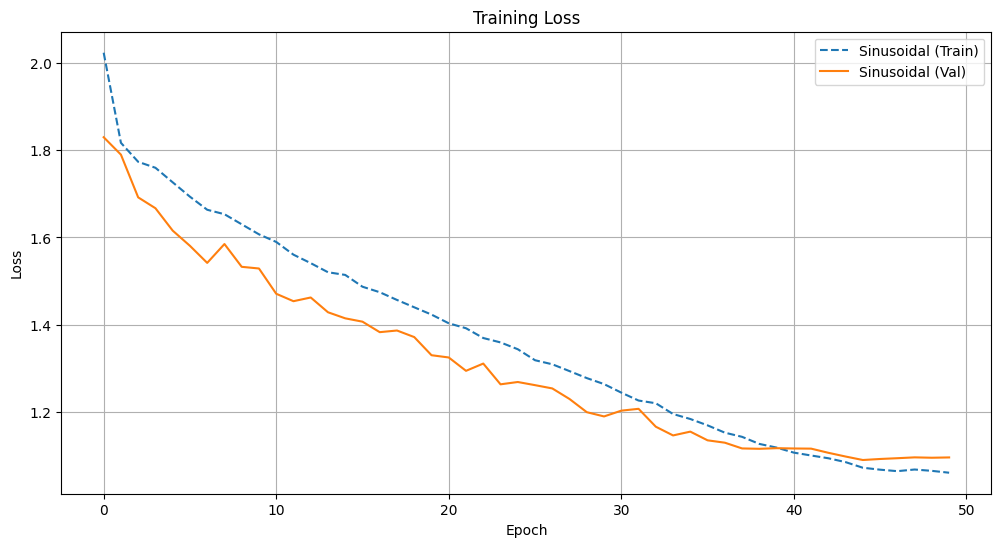

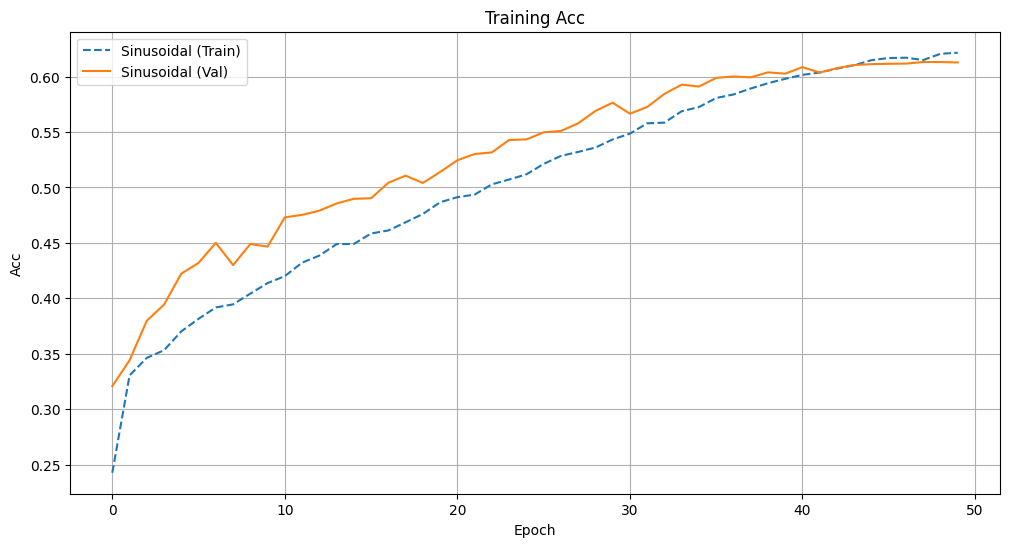

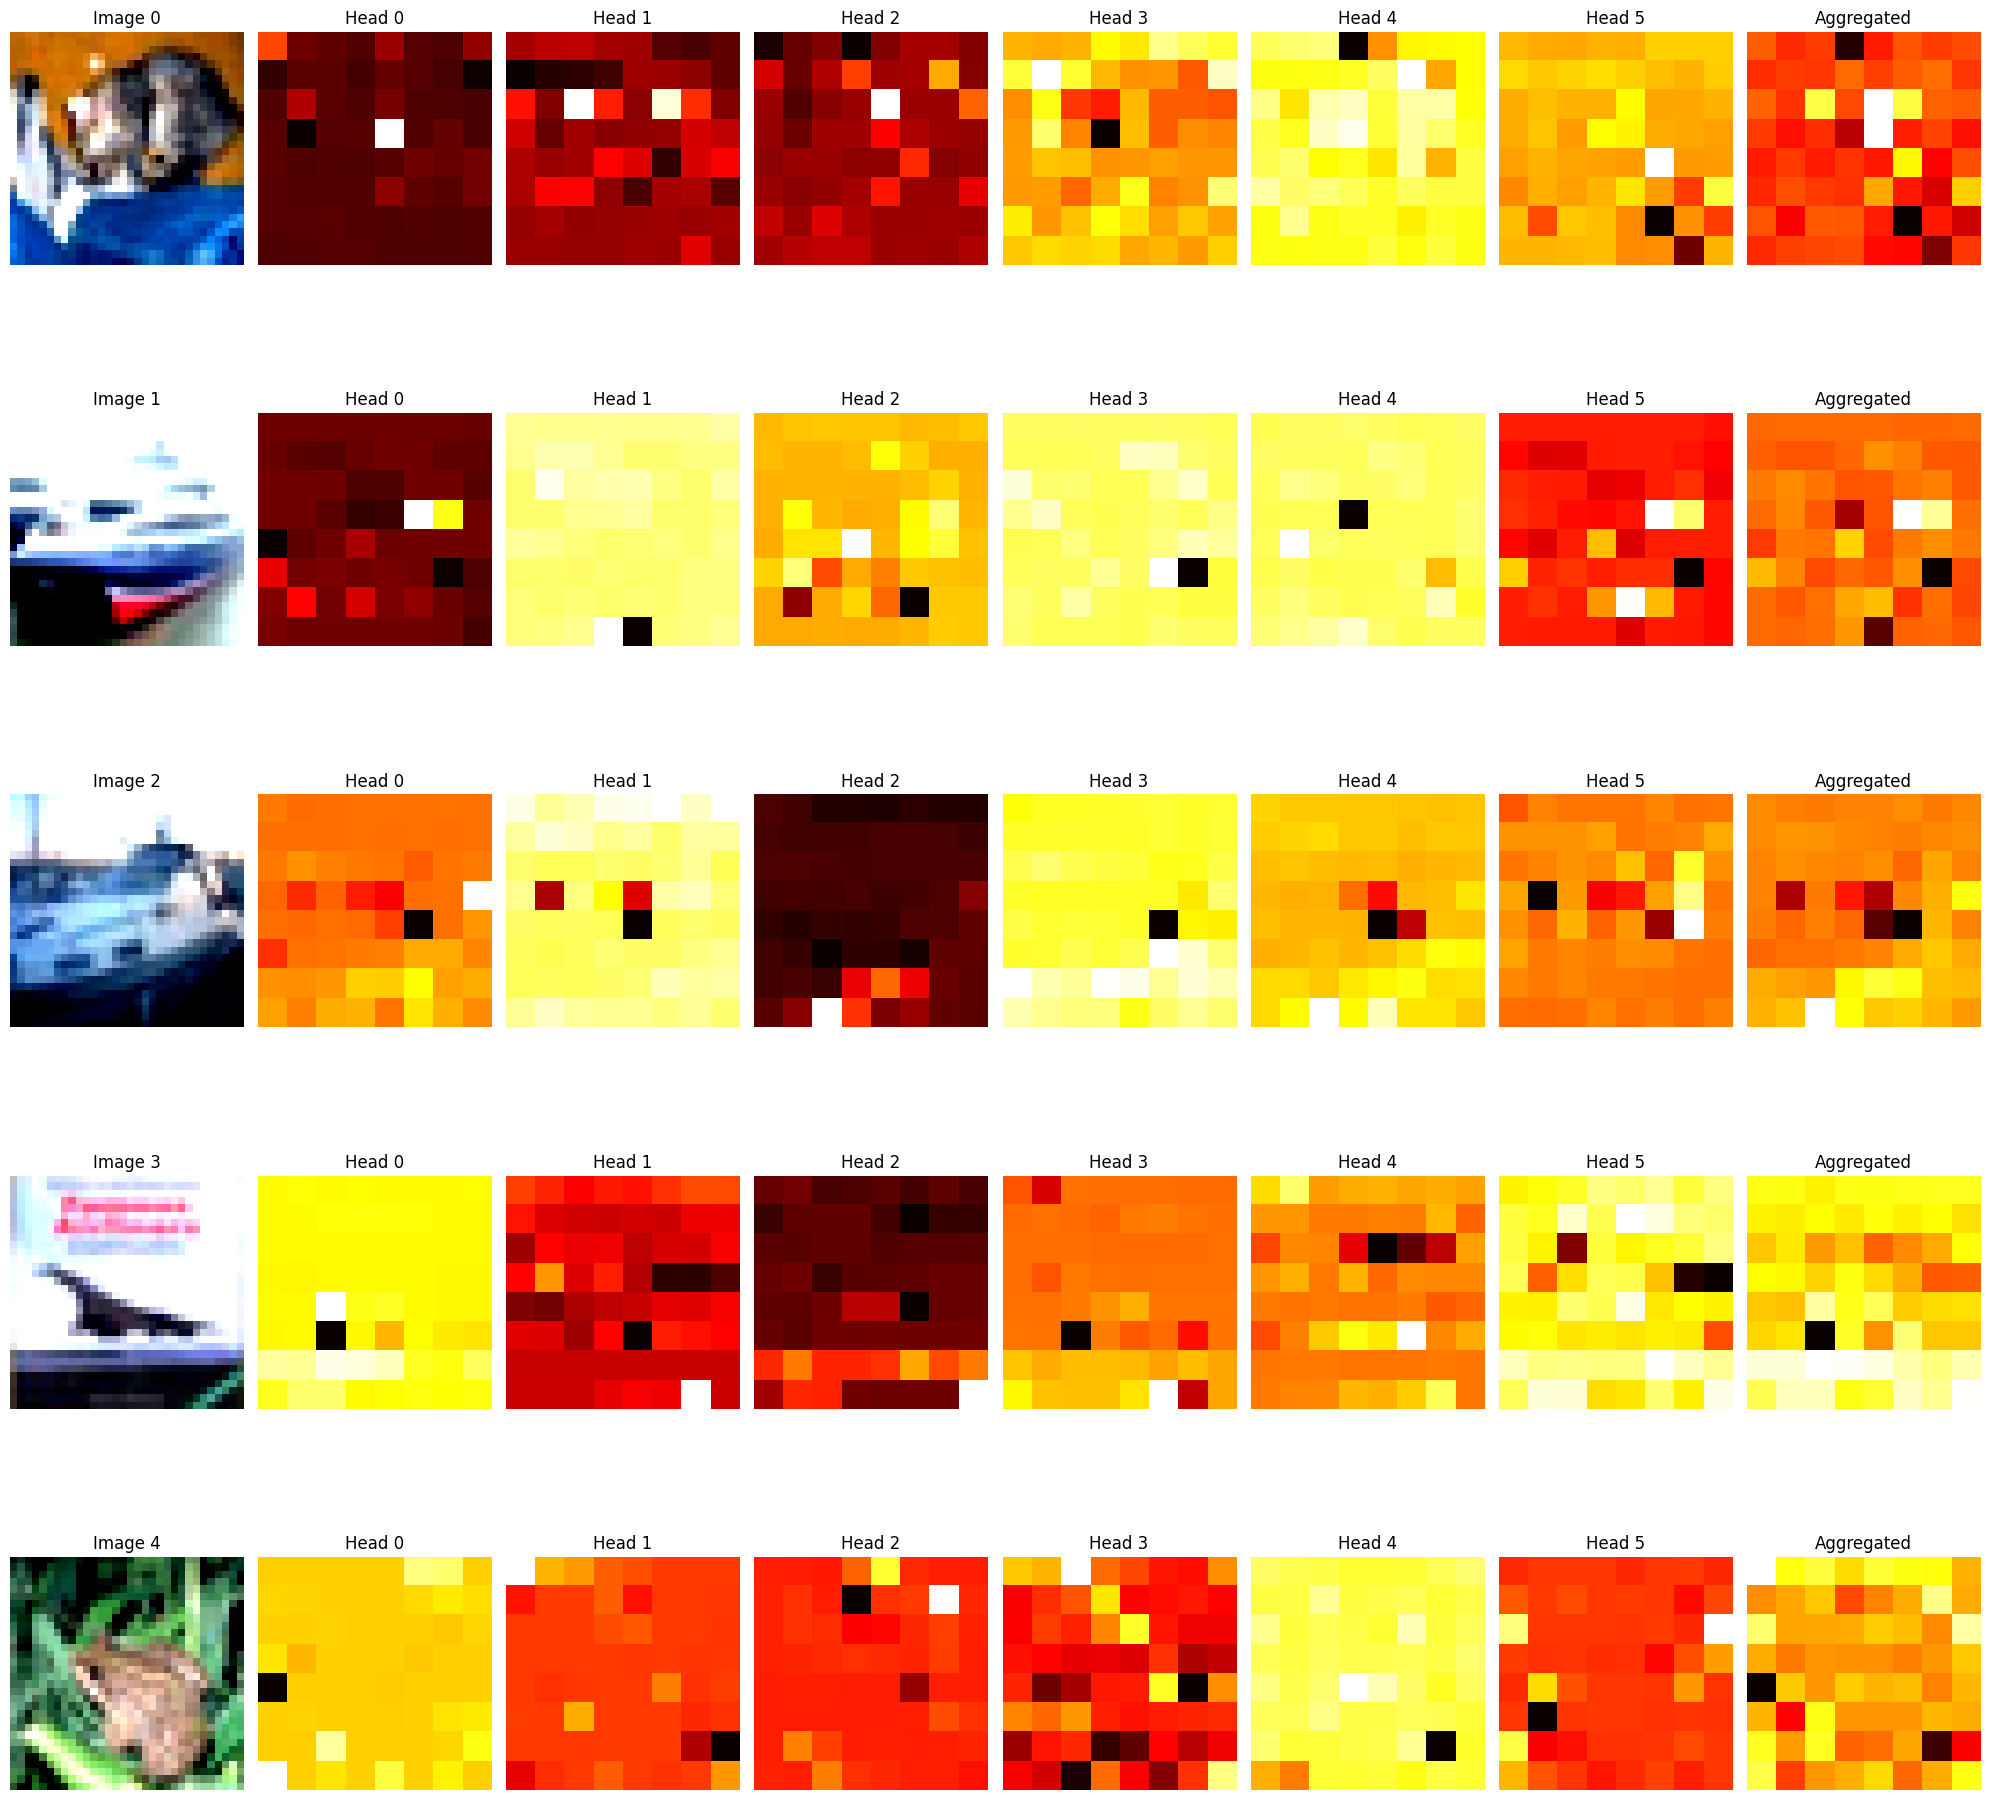

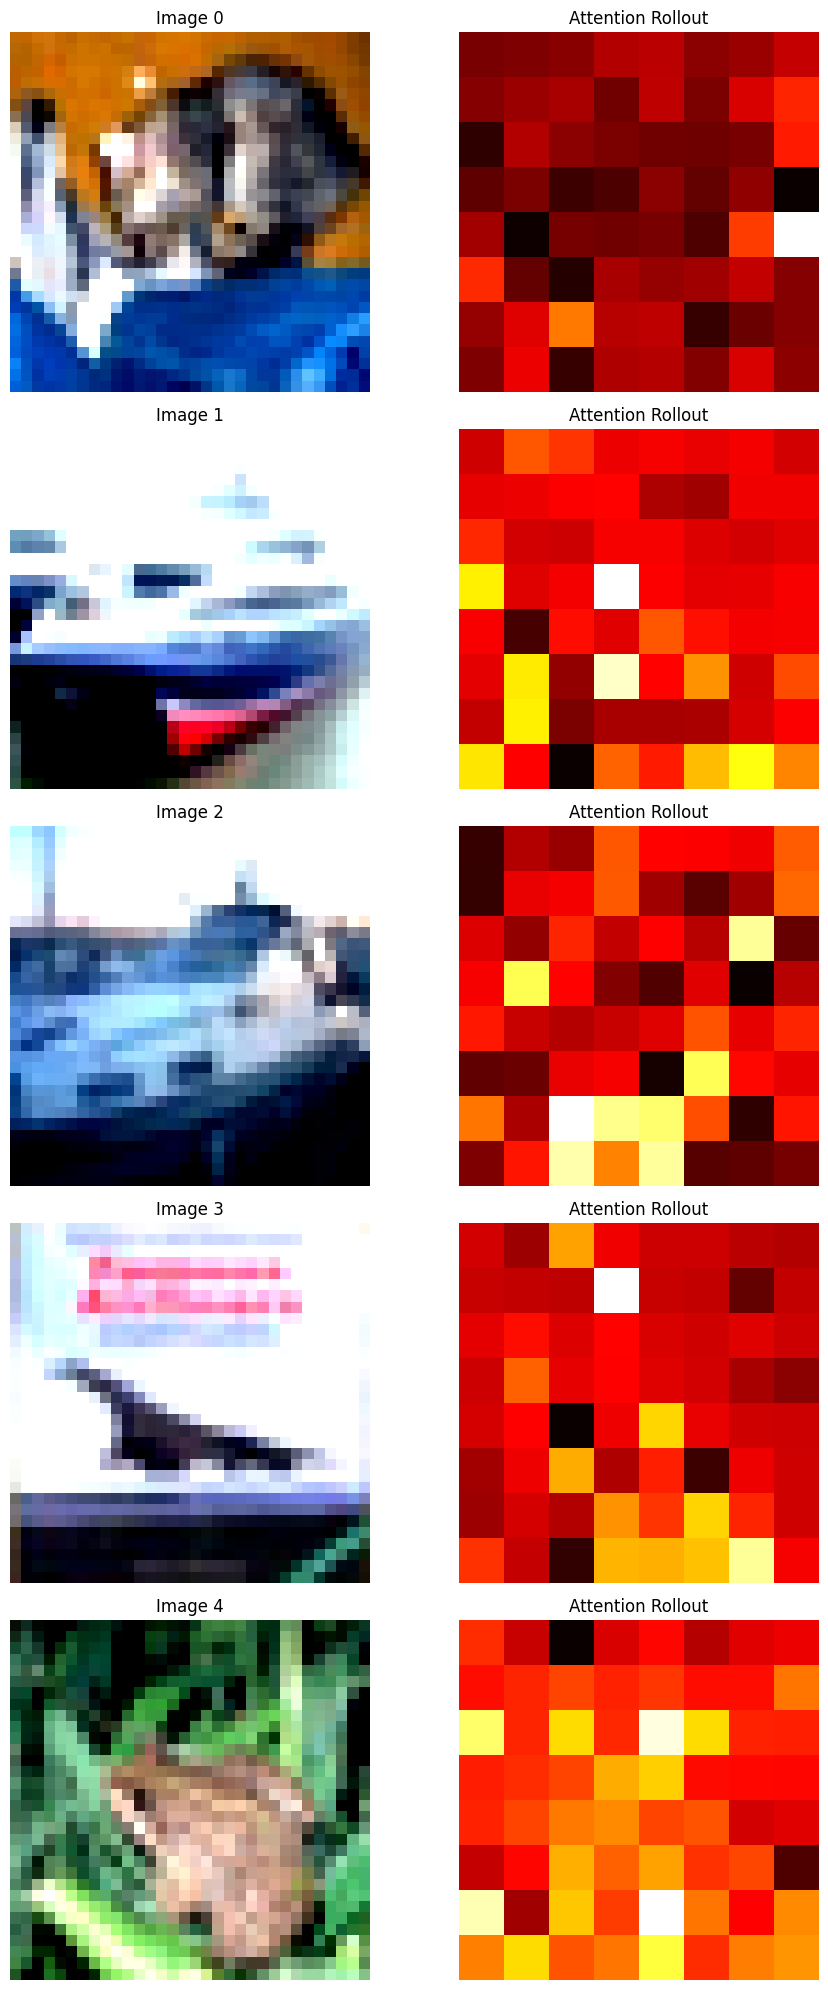

In [15]:
num_epochs = 50
selected_config = configs[4]  

model, history = train_model(selected_config, trainloader, testloader, num_epochs=num_epochs)

torch.save(model.state_dict(), f"results/diff_vit_{selected_config['name']}.pth")

fig = plot_training_history([history], [selected_config['name']], metric='loss')
fig.savefig(f"results/loss_curve_{selected_config['name']}.png")

fig = plot_training_history([history], [selected_config['name']], metric='acc')
fig.savefig(f"results/acc_curve_{selected_config['name']}.png")

fig = visualize_attention_maps(model, testloader, device)
fig.savefig(f"results/attention_maps_{selected_config['name']}.png")

fig = visualize_attention_rollout(model, testloader, device)
fig.savefig(f"results/attention_rollout_{selected_config['name']}.png")

if selected_config['pos_embed_type'] == 'learned_1d':
    fig = visualize_pos_embedding_similarity(model)
    if fig:
        fig.savefig(f"results/pos_embed_similarity_{selected_config['name']}.png")

print("Experiment completed and results saved!")


Training model with configuration: Patch Size 2


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.36it/s]


Epoch 1/50: Train Loss: 1.8871, Train Acc: 0.2868, Val Loss: 1.6232, Val Acc: 0.3933


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.40it/s]


Epoch 2/50: Train Loss: 1.6000, Train Acc: 0.4092, Val Loss: 1.4325, Val Acc: 0.4766


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.40it/s]


Epoch 3/50: Train Loss: 1.4682, Train Acc: 0.4628, Val Loss: 1.3839, Val Acc: 0.5097


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.39it/s]


Epoch 4/50: Train Loss: 1.3955, Train Acc: 0.4902, Val Loss: 1.3105, Val Acc: 0.5240


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.28it/s]


Epoch 5/50: Train Loss: 1.3369, Train Acc: 0.5122, Val Loss: 1.2906, Val Acc: 0.5355


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.25it/s]


Epoch 6/50: Train Loss: 1.2929, Train Acc: 0.5321, Val Loss: 1.1555, Val Acc: 0.5815


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.34it/s]


Epoch 7/50: Train Loss: 1.2536, Train Acc: 0.5443, Val Loss: 1.1447, Val Acc: 0.5815


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


Epoch 8/50: Train Loss: 1.2235, Train Acc: 0.5576, Val Loss: 1.1148, Val Acc: 0.5965


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.28it/s]


Epoch 9/50: Train Loss: 1.1856, Train Acc: 0.5726, Val Loss: 1.0864, Val Acc: 0.6081


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


Epoch 10/50: Train Loss: 1.1637, Train Acc: 0.5813, Val Loss: 1.0483, Val Acc: 0.6190


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.17it/s]


Epoch 11/50: Train Loss: 1.1304, Train Acc: 0.5944, Val Loss: 1.0186, Val Acc: 0.6293


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


Epoch 12/50: Train Loss: 1.1055, Train Acc: 0.6006, Val Loss: 0.9987, Val Acc: 0.6373


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.30it/s]


Epoch 13/50: Train Loss: 1.0778, Train Acc: 0.6138, Val Loss: 0.9787, Val Acc: 0.6443


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.33it/s]


Epoch 14/50: Train Loss: 1.0544, Train Acc: 0.6193, Val Loss: 0.9837, Val Acc: 0.6517


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.17it/s]


Epoch 15/50: Train Loss: 1.0205, Train Acc: 0.6359, Val Loss: 0.9451, Val Acc: 0.6586


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.34it/s]


Epoch 16/50: Train Loss: 1.0101, Train Acc: 0.6395, Val Loss: 0.9441, Val Acc: 0.6641


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.21it/s]


Epoch 17/50: Train Loss: 0.9853, Train Acc: 0.6472, Val Loss: 0.8788, Val Acc: 0.6884


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.28it/s]


Epoch 18/50: Train Loss: 0.9698, Train Acc: 0.6518, Val Loss: 0.8633, Val Acc: 0.6918


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.34it/s]


Epoch 19/50: Train Loss: 0.9403, Train Acc: 0.6635, Val Loss: 0.8525, Val Acc: 0.6938


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.33it/s]


Epoch 20/50: Train Loss: 0.9186, Train Acc: 0.6716, Val Loss: 0.8504, Val Acc: 0.7016


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.25it/s]


Epoch 21/50: Train Loss: 0.8997, Train Acc: 0.6784, Val Loss: 0.8452, Val Acc: 0.7011


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.25it/s]


Epoch 22/50: Train Loss: 0.8784, Train Acc: 0.6853, Val Loss: 0.8235, Val Acc: 0.7110


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.35it/s]


Epoch 23/50: Train Loss: 0.8527, Train Acc: 0.6988, Val Loss: 0.7893, Val Acc: 0.7206


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.28it/s]


Epoch 24/50: Train Loss: 0.8362, Train Acc: 0.6985, Val Loss: 0.8089, Val Acc: 0.7144


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.29it/s]


Epoch 25/50: Train Loss: 0.8208, Train Acc: 0.7057, Val Loss: 0.7718, Val Acc: 0.7310


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.33it/s]


Epoch 26/50: Train Loss: 0.7979, Train Acc: 0.7160, Val Loss: 0.7750, Val Acc: 0.7299


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.26it/s]


Epoch 27/50: Train Loss: 0.7721, Train Acc: 0.7247, Val Loss: 0.7551, Val Acc: 0.7320


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.32it/s]


Epoch 28/50: Train Loss: 0.7549, Train Acc: 0.7318, Val Loss: 0.7563, Val Acc: 0.7384


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.32it/s]


Epoch 29/50: Train Loss: 0.7392, Train Acc: 0.7364, Val Loss: 0.7556, Val Acc: 0.7384


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.26it/s]


Epoch 30/50: Train Loss: 0.7190, Train Acc: 0.7443, Val Loss: 0.7562, Val Acc: 0.7398


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.27it/s]


Epoch 31/50: Train Loss: 0.6954, Train Acc: 0.7512, Val Loss: 0.7316, Val Acc: 0.7446


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.34it/s]


Epoch 32/50: Train Loss: 0.6716, Train Acc: 0.7626, Val Loss: 0.7195, Val Acc: 0.7484


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.27it/s]


Epoch 33/50: Train Loss: 0.6547, Train Acc: 0.7664, Val Loss: 0.7138, Val Acc: 0.7502


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.30it/s]


Epoch 34/50: Train Loss: 0.6328, Train Acc: 0.7739, Val Loss: 0.7164, Val Acc: 0.7532


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.32it/s]


Epoch 35/50: Train Loss: 0.6179, Train Acc: 0.7802, Val Loss: 0.7002, Val Acc: 0.7618


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


Epoch 36/50: Train Loss: 0.5990, Train Acc: 0.7846, Val Loss: 0.7109, Val Acc: 0.7575


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.29it/s]


Epoch 37/50: Train Loss: 0.5789, Train Acc: 0.7942, Val Loss: 0.7392, Val Acc: 0.7505


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.35it/s]


Epoch 38/50: Train Loss: 0.5691, Train Acc: 0.7969, Val Loss: 0.7103, Val Acc: 0.7583


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.33it/s]


Epoch 39/50: Train Loss: 0.5445, Train Acc: 0.8059, Val Loss: 0.7156, Val Acc: 0.7594


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.26it/s]


Epoch 40/50: Train Loss: 0.5286, Train Acc: 0.8127, Val Loss: 0.7238, Val Acc: 0.7547


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.27it/s]


Epoch 41/50: Train Loss: 0.5151, Train Acc: 0.8169, Val Loss: 0.7219, Val Acc: 0.7587


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.28it/s]


Epoch 42/50: Train Loss: 0.5061, Train Acc: 0.8197, Val Loss: 0.7213, Val Acc: 0.7589


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Epoch 43/50: Train Loss: 0.4882, Train Acc: 0.8263, Val Loss: 0.7147, Val Acc: 0.7611


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.35it/s]


Epoch 44/50: Train Loss: 0.4801, Train Acc: 0.8322, Val Loss: 0.7196, Val Acc: 0.7646


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.30it/s]


Epoch 45/50: Train Loss: 0.4721, Train Acc: 0.8318, Val Loss: 0.7218, Val Acc: 0.7646


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.36it/s]


Epoch 46/50: Train Loss: 0.4641, Train Acc: 0.8343, Val Loss: 0.7218, Val Acc: 0.7632


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.33it/s]


Epoch 47/50: Train Loss: 0.4548, Train Acc: 0.8394, Val Loss: 0.7204, Val Acc: 0.7619


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.30it/s]


Epoch 48/50: Train Loss: 0.4567, Train Acc: 0.8361, Val Loss: 0.7230, Val Acc: 0.7634


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.21it/s]


Epoch 49/50: Train Loss: 0.4516, Train Acc: 0.8393, Val Loss: 0.7229, Val Acc: 0.7628


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.32it/s]


Epoch 50/50: Train Loss: 0.4490, Train Acc: 0.8419, Val Loss: 0.7228, Val Acc: 0.7630


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.4979501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4629833..1.5354269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22441113..1.4005105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4391681..1.2814069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49

Experiment completed and results saved!


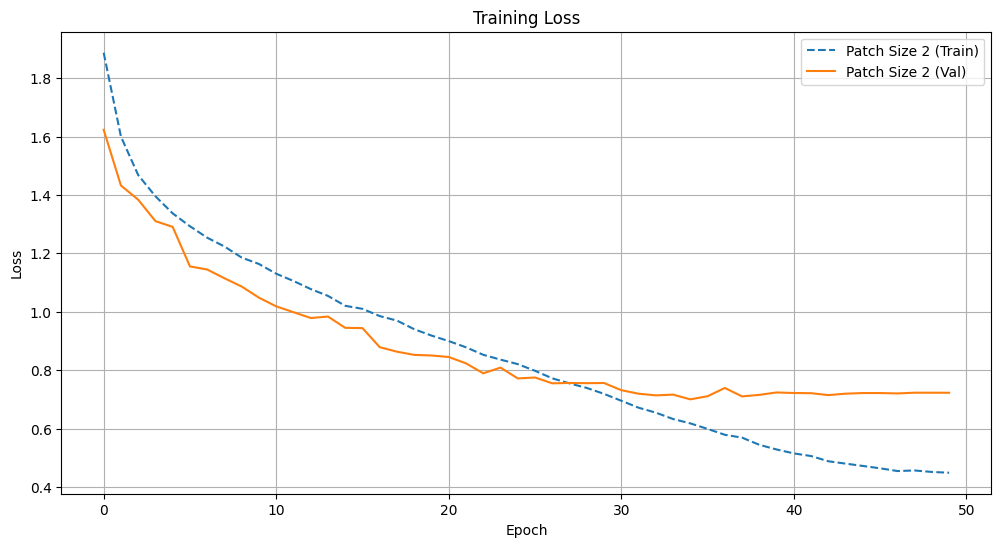

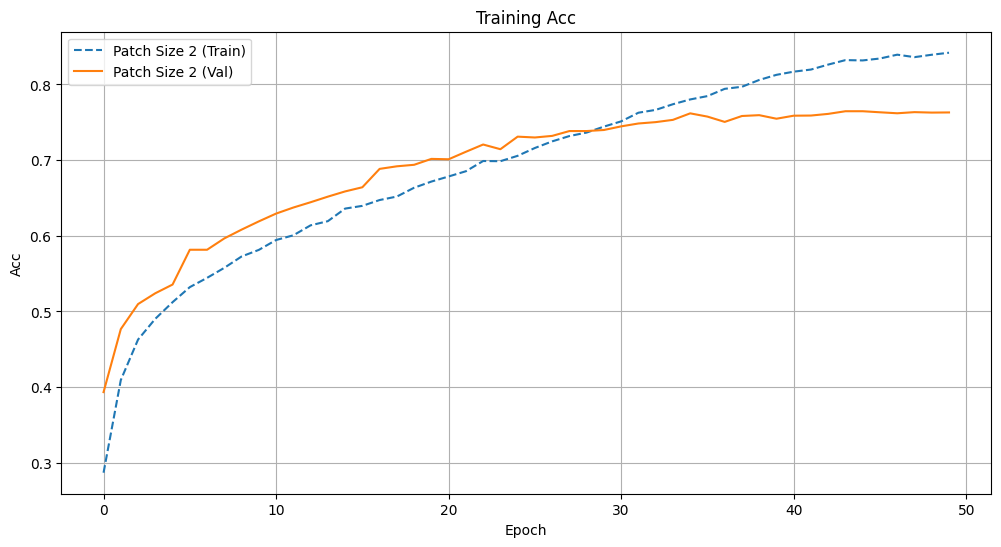

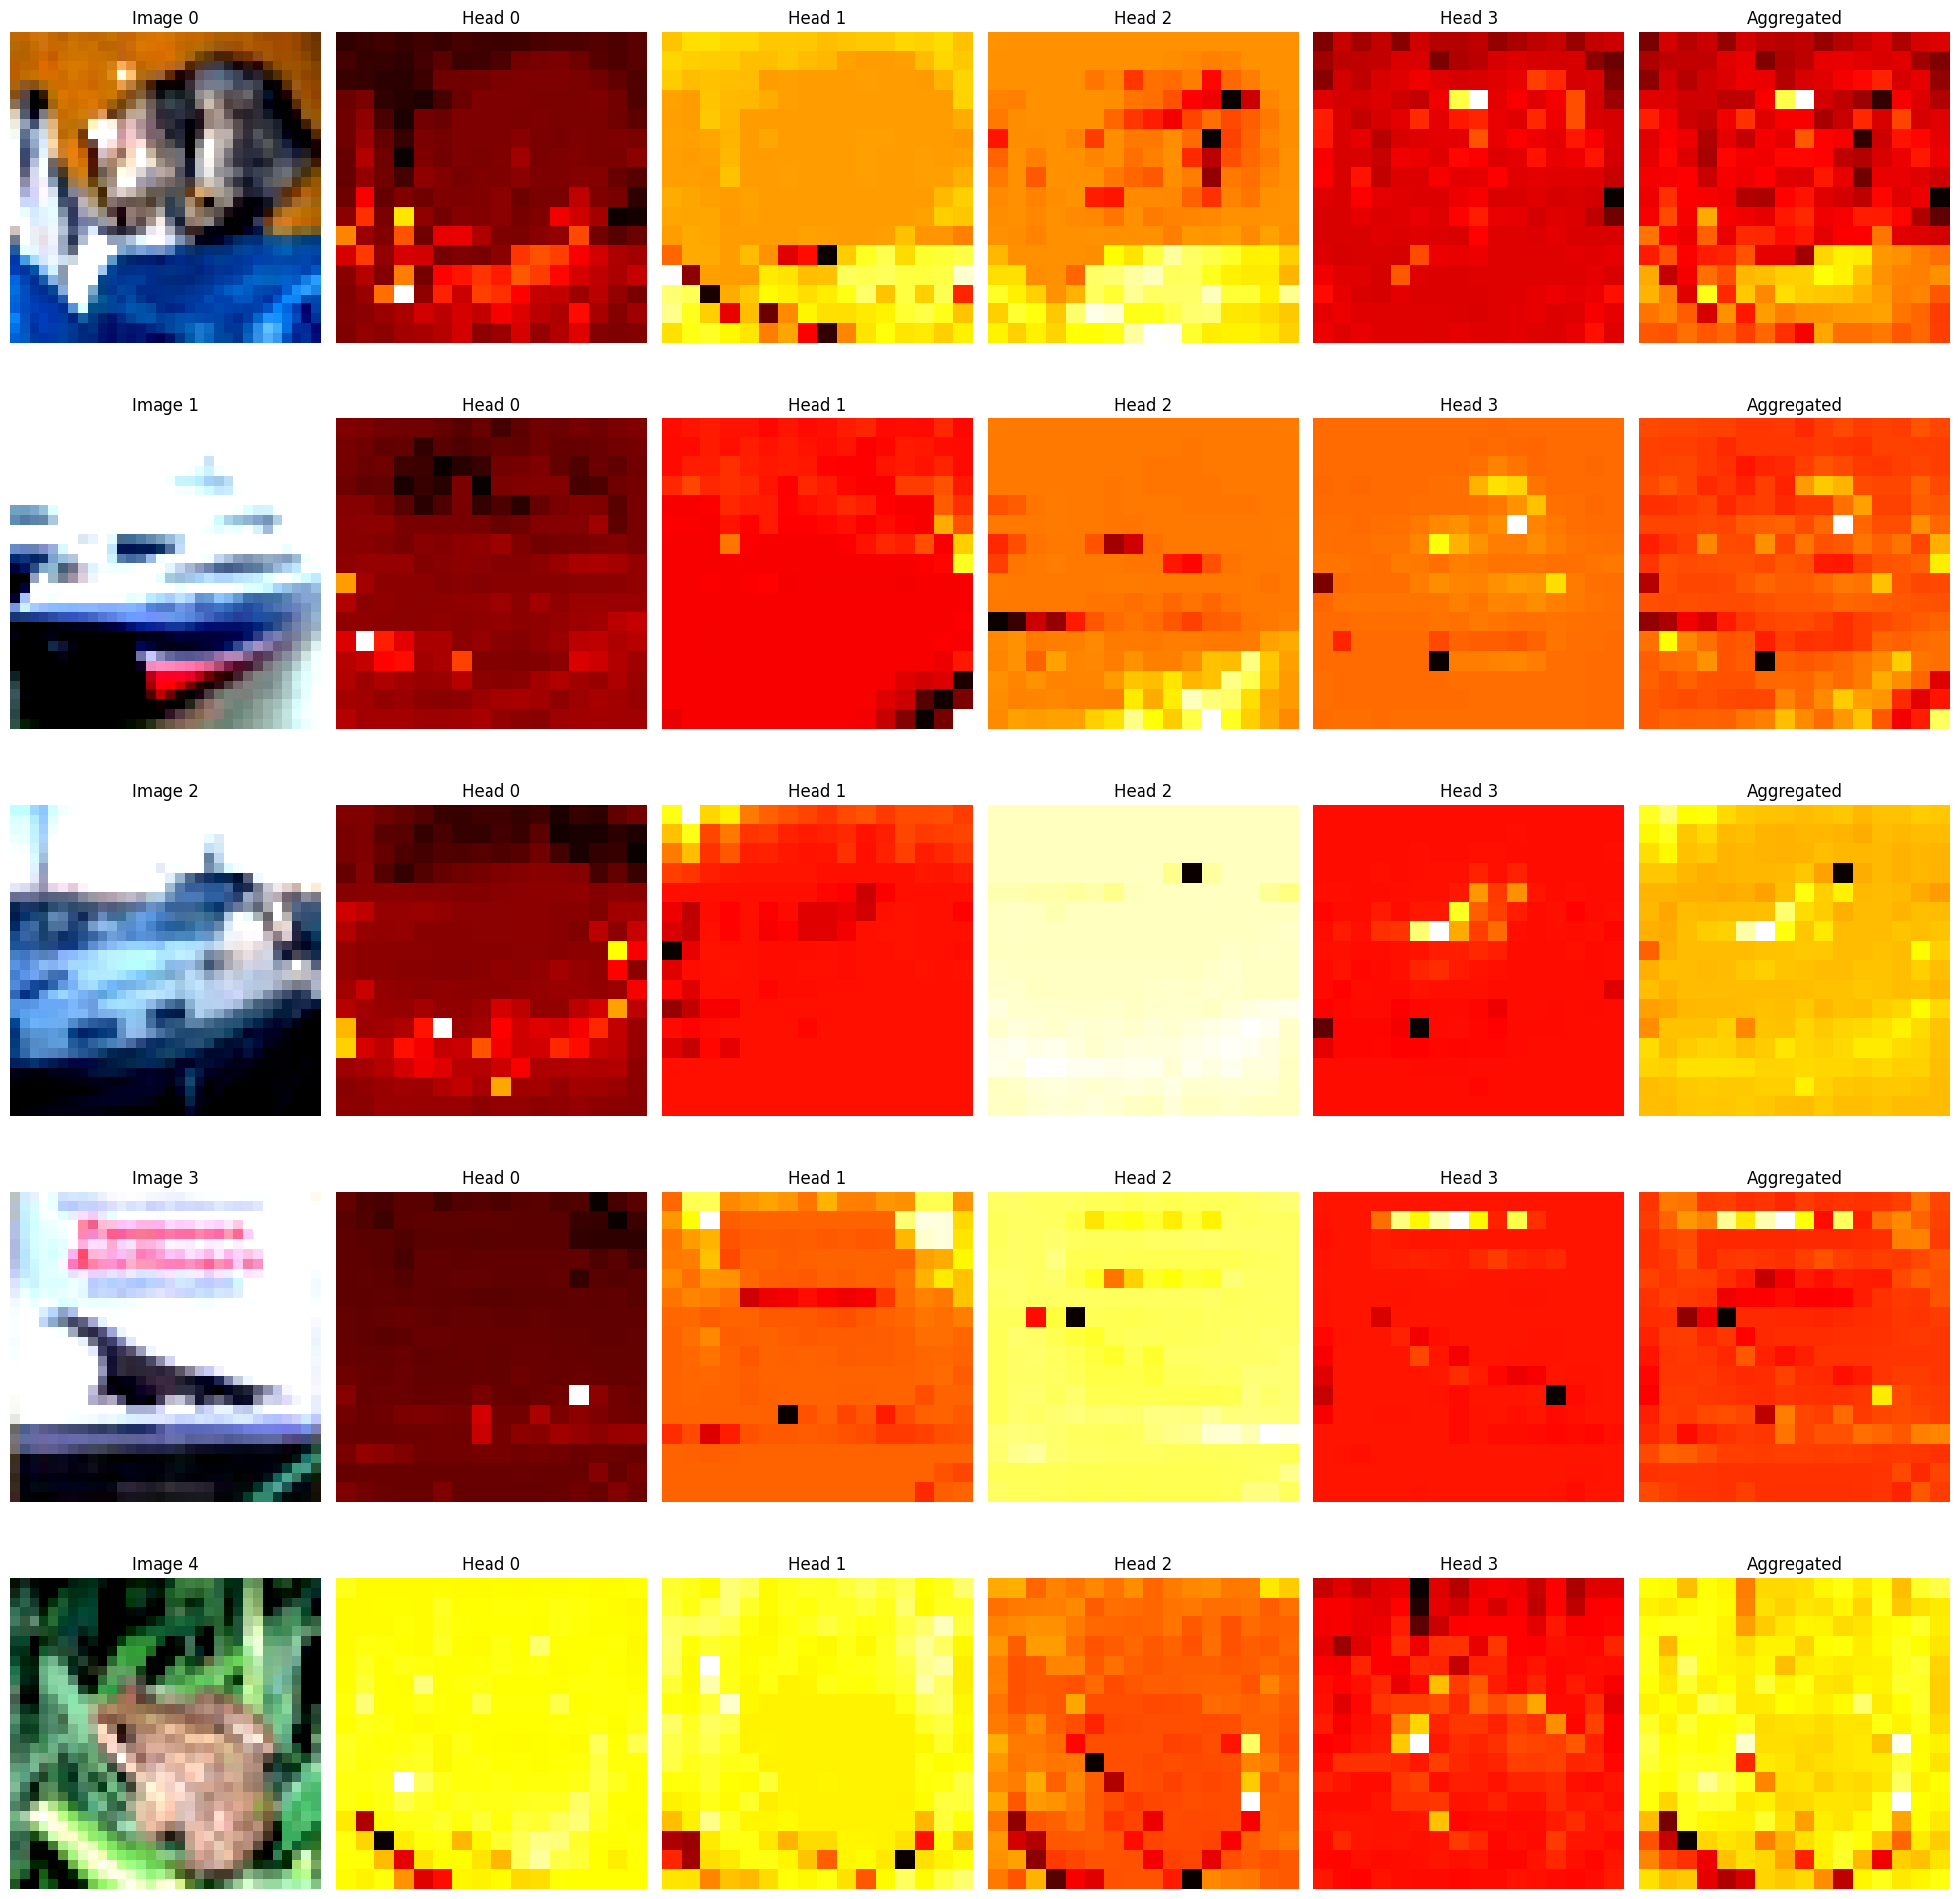

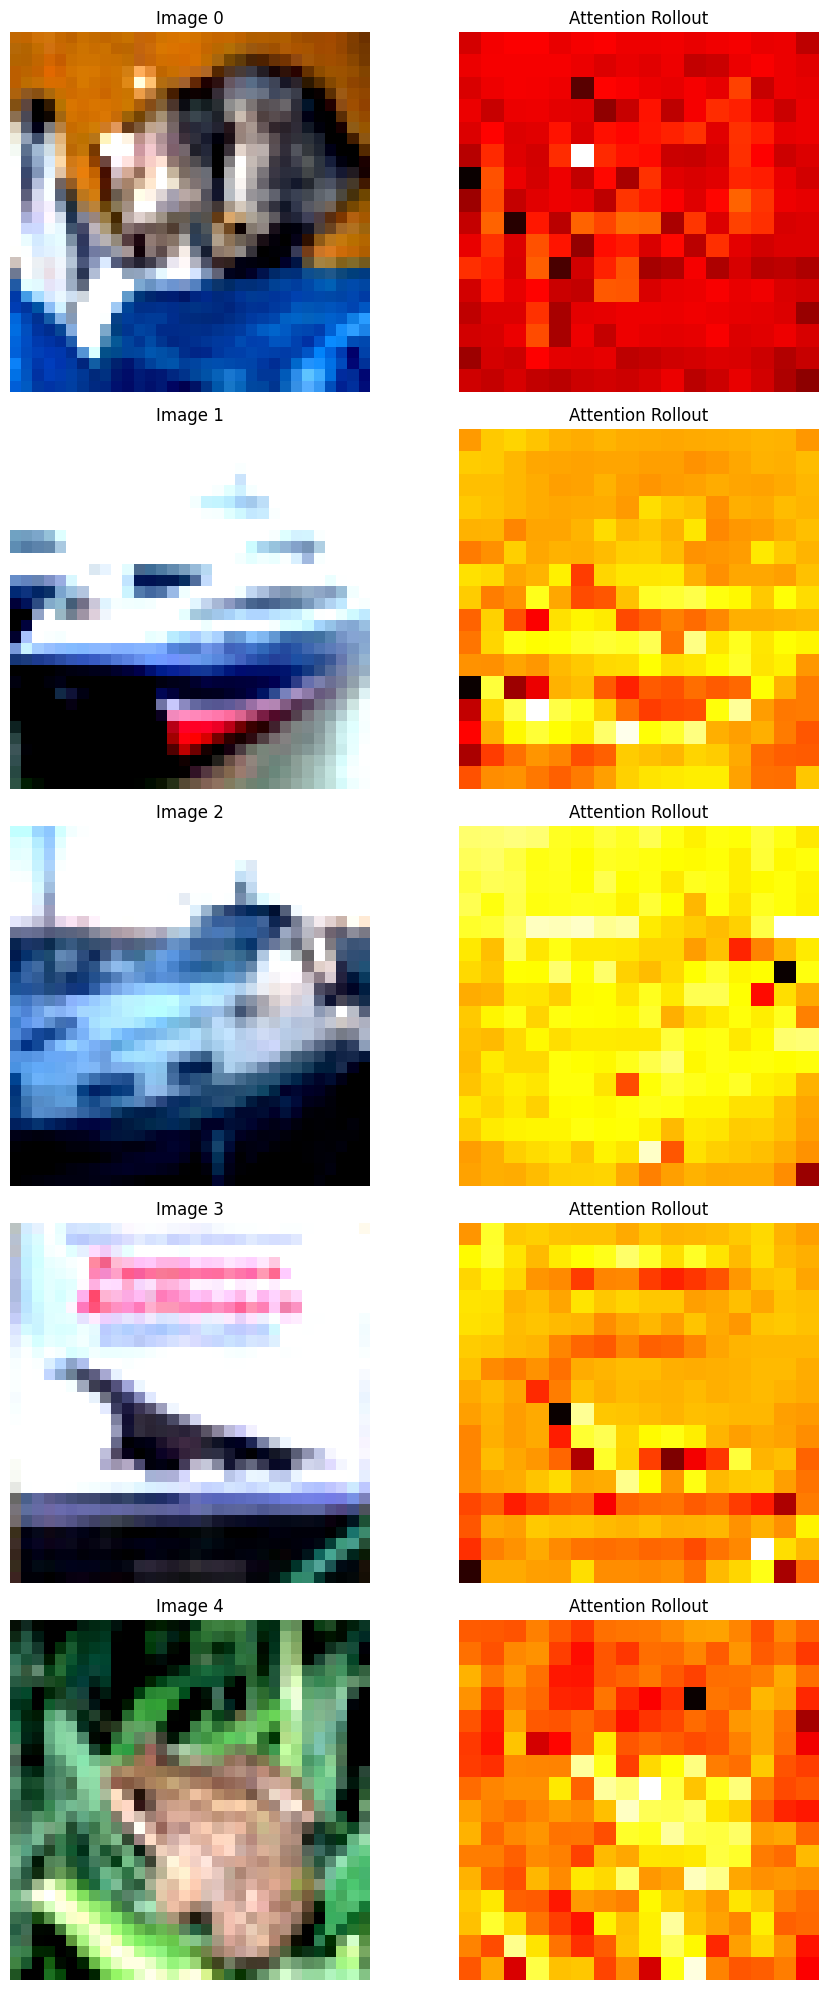

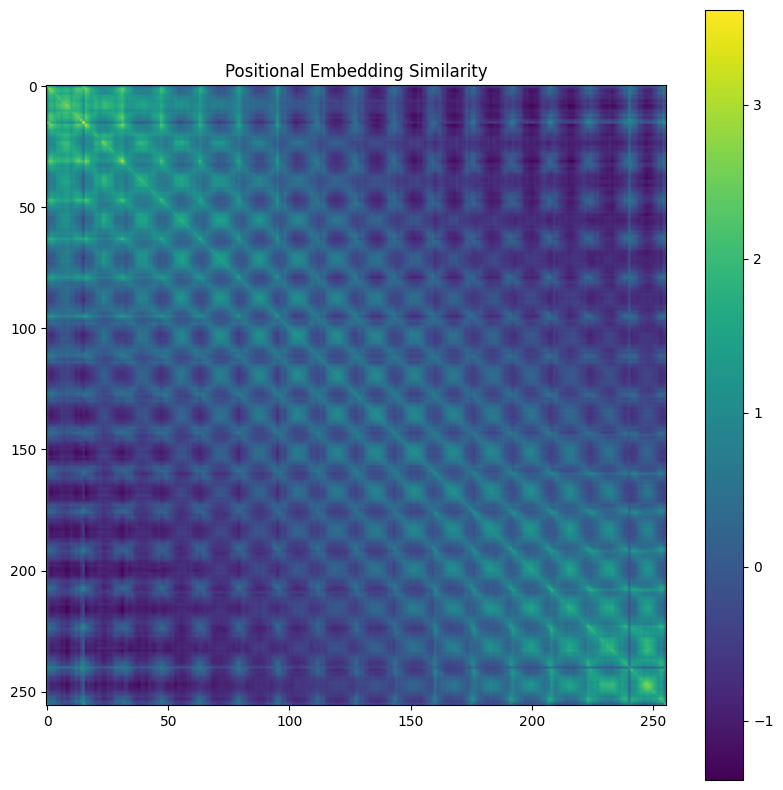

In [12]:
num_epochs = 50
selected_config = configs[5]  

model, history = train_model(selected_config, trainloader, testloader, num_epochs=num_epochs)

torch.save(model.state_dict(), f"results/diff_vit_{selected_config['name']}.pth")

fig = plot_training_history([history], [selected_config['name']], metric='loss')
fig.savefig(f"results/loss_curve_{selected_config['name']}.png")

fig = plot_training_history([history], [selected_config['name']], metric='acc')
fig.savefig(f"results/acc_curve_{selected_config['name']}.png")

fig = visualize_attention_maps(model, testloader, device)
fig.savefig(f"results/attention_maps_{selected_config['name']}.png")

fig = visualize_attention_rollout(model, testloader, device)
fig.savefig(f"results/attention_rollout_{selected_config['name']}.png")

if selected_config['pos_embed_type'] == 'learned_1d':
    fig = visualize_pos_embedding_similarity(model)
    if fig:
        fig.savefig(f"results/pos_embed_similarity_{selected_config['name']}.png")

print("Experiment completed and results saved!")


In [ ]:
num_epochs = 50
selected_config = configs[6]  

model, history = train_model(selected_config, trainloader, testloader, num_epochs=num_epochs)

torch.save(model.state_dict(), f"results/diff_vit_{selected_config['name']}.pth")

fig = plot_training_history([history], [selected_config['name']], metric='loss')
fig.savefig(f"results/loss_curve_{selected_config['name']}.png")

fig = plot_training_history([history], [selected_config['name']], metric='acc')
fig.savefig(f"results/acc_curve_{selected_config['name']}.png")

fig = visualize_attention_maps(model, testloader, device)
fig.savefig(f"results/attention_maps_{selected_config['name']}.png")

fig = visualize_attention_rollout(model, testloader, device)
fig.savefig(f"results/attention_rollout_{selected_config['name']}.png")

if selected_config['pos_embed_type'] == 'learned_1d':
    fig = visualize_pos_embedding_similarity(model)
    if fig:
        fig.savefig(f"results/pos_embed_similarity_{selected_config['name']}.png")

print("Experiment completed and results saved!")


Training model with configuration: Learned 2D


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.34it/s]


Epoch 1/50: Train Loss: 2.0073, Train Acc: 0.2412, Val Loss: 1.8152, Val Acc: 0.3138


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.75it/s]


Epoch 2/50: Train Loss: 1.8333, Train Acc: 0.3106, Val Loss: 1.7776, Val Acc: 0.3391


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Epoch 3/50: Train Loss: 1.7857, Train Acc: 0.3304, Val Loss: 1.8477, Val Acc: 0.3196


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.33it/s]


Epoch 4/50: Train Loss: 1.7616, Train Acc: 0.3451, Val Loss: 1.7249, Val Acc: 0.3626


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.26it/s]


Epoch 5/50: Train Loss: 1.7127, Train Acc: 0.3653, Val Loss: 1.6498, Val Acc: 0.3918


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Epoch 6/50: Train Loss: 1.6769, Train Acc: 0.3790, Val Loss: 1.6292, Val Acc: 0.4015


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.37it/s]


Epoch 7/50: Train Loss: 1.6329, Train Acc: 0.3983, Val Loss: 1.5962, Val Acc: 0.4203


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Epoch 8/50: Train Loss: 1.6093, Train Acc: 0.4079, Val Loss: 1.5399, Val Acc: 0.4358


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.35it/s]


Epoch 9/50: Train Loss: 1.5755, Train Acc: 0.4220, Val Loss: 1.5122, Val Acc: 0.4499


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Epoch 10/50: Train Loss: 1.5398, Train Acc: 0.4392, Val Loss: 1.4816, Val Acc: 0.4718


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.40it/s]


Epoch 11/50: Train Loss: 1.5136, Train Acc: 0.4509, Val Loss: 1.4688, Val Acc: 0.4614


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.36it/s]


Epoch 12/50: Train Loss: 1.4750, Train Acc: 0.4616, Val Loss: 1.3980, Val Acc: 0.4995


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.39it/s]


Epoch 13/50: Train Loss: 1.4514, Train Acc: 0.4705, Val Loss: 1.3655, Val Acc: 0.5065


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.10it/s]


Epoch 14/50: Train Loss: 1.4371, Train Acc: 0.4759, Val Loss: 1.3423, Val Acc: 0.5159


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Epoch 15/50: Train Loss: 1.4103, Train Acc: 0.4830, Val Loss: 1.4048, Val Acc: 0.5013


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.41it/s]


Epoch 16/50: Train Loss: 1.3804, Train Acc: 0.4983, Val Loss: 1.3658, Val Acc: 0.5132


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.22it/s]


Epoch 17/50: Train Loss: 1.3541, Train Acc: 0.5059, Val Loss: 1.2853, Val Acc: 0.5356


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Epoch 18/50: Train Loss: 1.3309, Train Acc: 0.5154, Val Loss: 1.2532, Val Acc: 0.5471


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.35it/s]


Epoch 19/50: Train Loss: 1.3115, Train Acc: 0.5247, Val Loss: 1.2143, Val Acc: 0.5589


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.84it/s]


Epoch 20/50: Train Loss: 1.2844, Train Acc: 0.5359, Val Loss: 1.1891, Val Acc: 0.5663


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.33it/s]


Epoch 21/50: Train Loss: 1.2596, Train Acc: 0.5419, Val Loss: 1.1620, Val Acc: 0.5780


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.36it/s]


Epoch 22/50: Train Loss: 1.2366, Train Acc: 0.5534, Val Loss: 1.1630, Val Acc: 0.5780


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.40it/s]


Epoch 23/50: Train Loss: 1.2124, Train Acc: 0.5615, Val Loss: 1.1411, Val Acc: 0.5854


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Epoch 24/50: Train Loss: 1.1874, Train Acc: 0.5712, Val Loss: 1.0989, Val Acc: 0.6066


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.42it/s]


Epoch 25/50: Train Loss: 1.1564, Train Acc: 0.5849, Val Loss: 1.1297, Val Acc: 0.5942


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.39it/s]


Epoch 26/50: Train Loss: 1.1219, Train Acc: 0.5950, Val Loss: 1.0461, Val Acc: 0.6223


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.39it/s]


Epoch 27/50: Train Loss: 1.1060, Train Acc: 0.6024, Val Loss: 1.0407, Val Acc: 0.6291


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.82it/s]


Epoch 28/50: Train Loss: 1.0725, Train Acc: 0.6137, Val Loss: 1.0096, Val Acc: 0.6322


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Epoch 29/50: Train Loss: 1.0535, Train Acc: 0.6222, Val Loss: 0.9854, Val Acc: 0.6450


Training:  93%|█████████▎| 362/391 [01:24<00:06,  4.22it/s]

1. Default Configuration 

Shows steady convergence with final validation accuracy of 52.38%, with train and validation losses tracking closely.
Training loss (1.3157) is slightly lower than validation loss (1.3392), indicating minimal overfitting.
Represents the baseline performance with patch size 4, embedding dimension 384, and 8 transformer layers.

2. Larger Model 

The larger model (embed_dim=512, depth=12) converges to higher final loss values (1.6649) and lower accuracy (38.85%).
Shows consistently worse performance than the default configuration, suggesting model capacity is too large for the dataset.
Exhibits more oscillations in validation loss, indicating potential instability with the increased parameter count.

3. Lambda 0.3 

Lower lambda value (0.3) in differential attention yields the best validation accuracy (64.45%) among the embedding variants.
Shows faster convergence and consistently lower validation loss compared to the default model.
The reduced lambda parameter effectively balances attention signal strength, allowing better feature extraction.

4. No Positional Embedding 

Surprisingly achieves 60.74% validation accuracy despite lacking positional information.
Shows increasing gap between training and validation loss after epoch 30, indicating overfitting.
Model learns to extract useful features from patch content alone but hits a performance ceiling without spatial context.

5. Sinusoidal Positional Embedding 

Achieves 61.27% validation accuracy, slightly better than no positional embedding but worse than learned embeddings.
Shows consistent convergence pattern with moderate gap between training and validation losses.
Fixed mathematical encoding provides useful spatial information but lacks the adaptability of learned embeddings.

6. Patch Size 2 

Significantly outperforms other configurations with 76.30% validation accuracy.
Shows notable gap between training (0.4490) and validation loss (0.7228), indicating some overfitting.
Smaller patches provide higher resolution input, allowing the model to capture finer details despite having fewer parameters.

7. Learned 2D Positional Embedding

Training stopped early at epoch 29, achieving 64.50% validation accuracy.
Provides better spatial encoding than 1D embeddings, resulting in faster convergence.
Balances complexity and performance, explicitly modeling 2D relationships in the flattened sequence.

1. Patch Size Impact: Smaller patch size (2) dramatically improves performance by preserving more spatial information.

2. Positional Embedding: Learned embeddings (1D and 2D) outperform fixed sinusoidal and no embeddings, with 2D showing particular promise.

3. Other Hyperparameters: Lower lambda value (0.3) improves differential attention, while larger models struggle with overfitting.

Best Configuration: Patch Size 2 model is clearly superior with 76.30% accuracy, despite having fewer parameters than the larger variants.